# Amplitude Source Location (ASL)

## 1. Introduction

### 1.1 Review

In the previous tutorial, we estimated Reduced Displacement by assuming a source location, e.g. the summit of a volcano. But it would be better if we locate volcano-seismic signals, and then compute Reduced Displacement. Most volcano-seismic signals cannot be located using traditional differential travel-time techniques, because they lack identifiable phases (sources are quasi-continuous, so phases are arriving all the time). So what else can we do?

### 1.2 Motivation
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured), and applying calibration constants. We'll replicate that here, but use DSAM data, which has already been instrument-corrected. For simplicity - and speed which was important for a real-time system - we ignore the vertical dimension (topography and station elevations ignored), and assume an isotropic, homogeneous half-space.

First, we will run a simulation, to demonstrate that our location technique works. Then we will compute locations for real DSAM data, and then for a known pyroclastic flow signal.

### 1.3 Setup

We need to import the following, to set things up.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import obspy
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
from SAM import DSAM
from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM
SDS_DIR = Path.cwd().parents[1].joinpath('data','continuous','SDS')
SAM_DIR = Path.cwd().parents[1].joinpath('data','continuous','SAM')
RESPONSE_DIR = Path.cwd().parents[1].joinpath('data','responses')

## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

-62.260527595207385 -62.093472404792614 16.631 16.790999999999997
Loading EarthReliefData-62.177.16.711.0.03s.pkl
Making color pallet
Calling grdimage


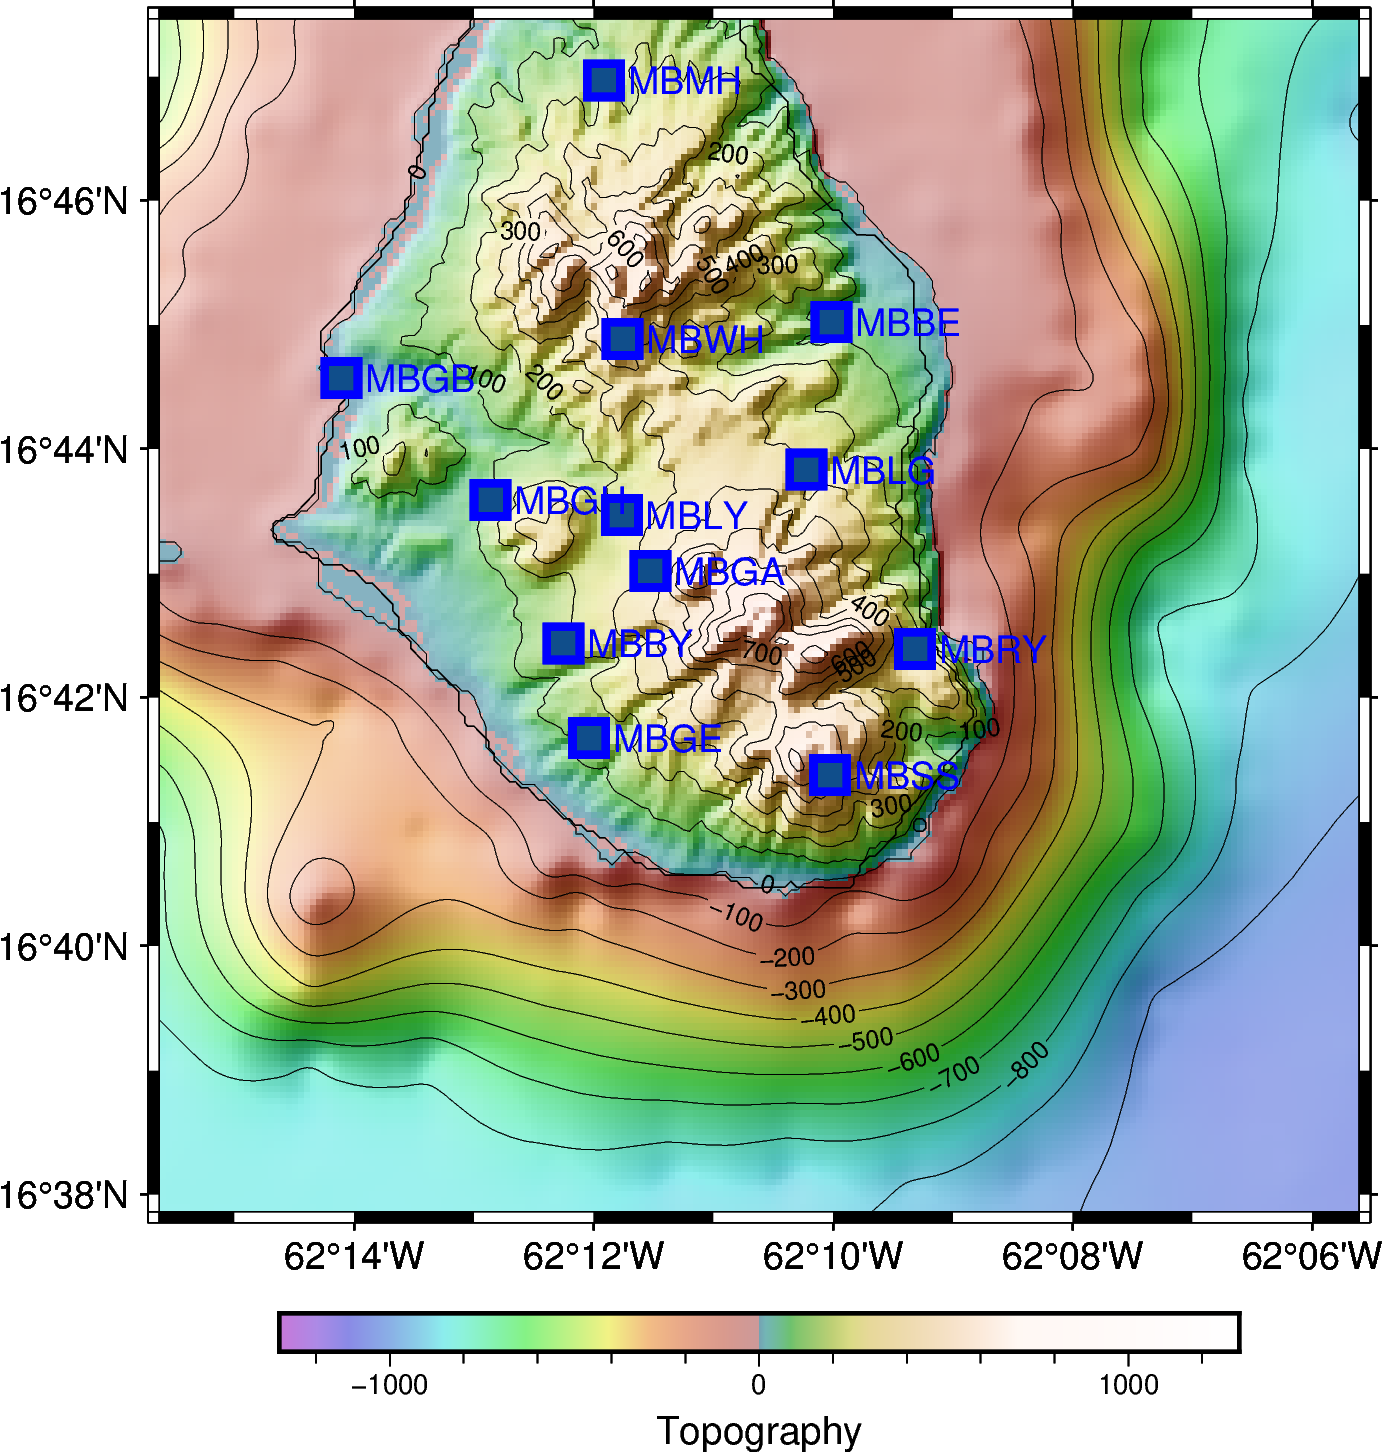

In [2]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
#import pygmt
#pygmt.config(GMT_DATA_SERVER="https://oceania.generic-mapping-tools.org")
montserrat_topo_map(inv=invMVO, show=True, add_labels=True, resolution='03s');

### 2.2 Define a grid of source locations and reduced displacement at those nodes

METRIC:  mean


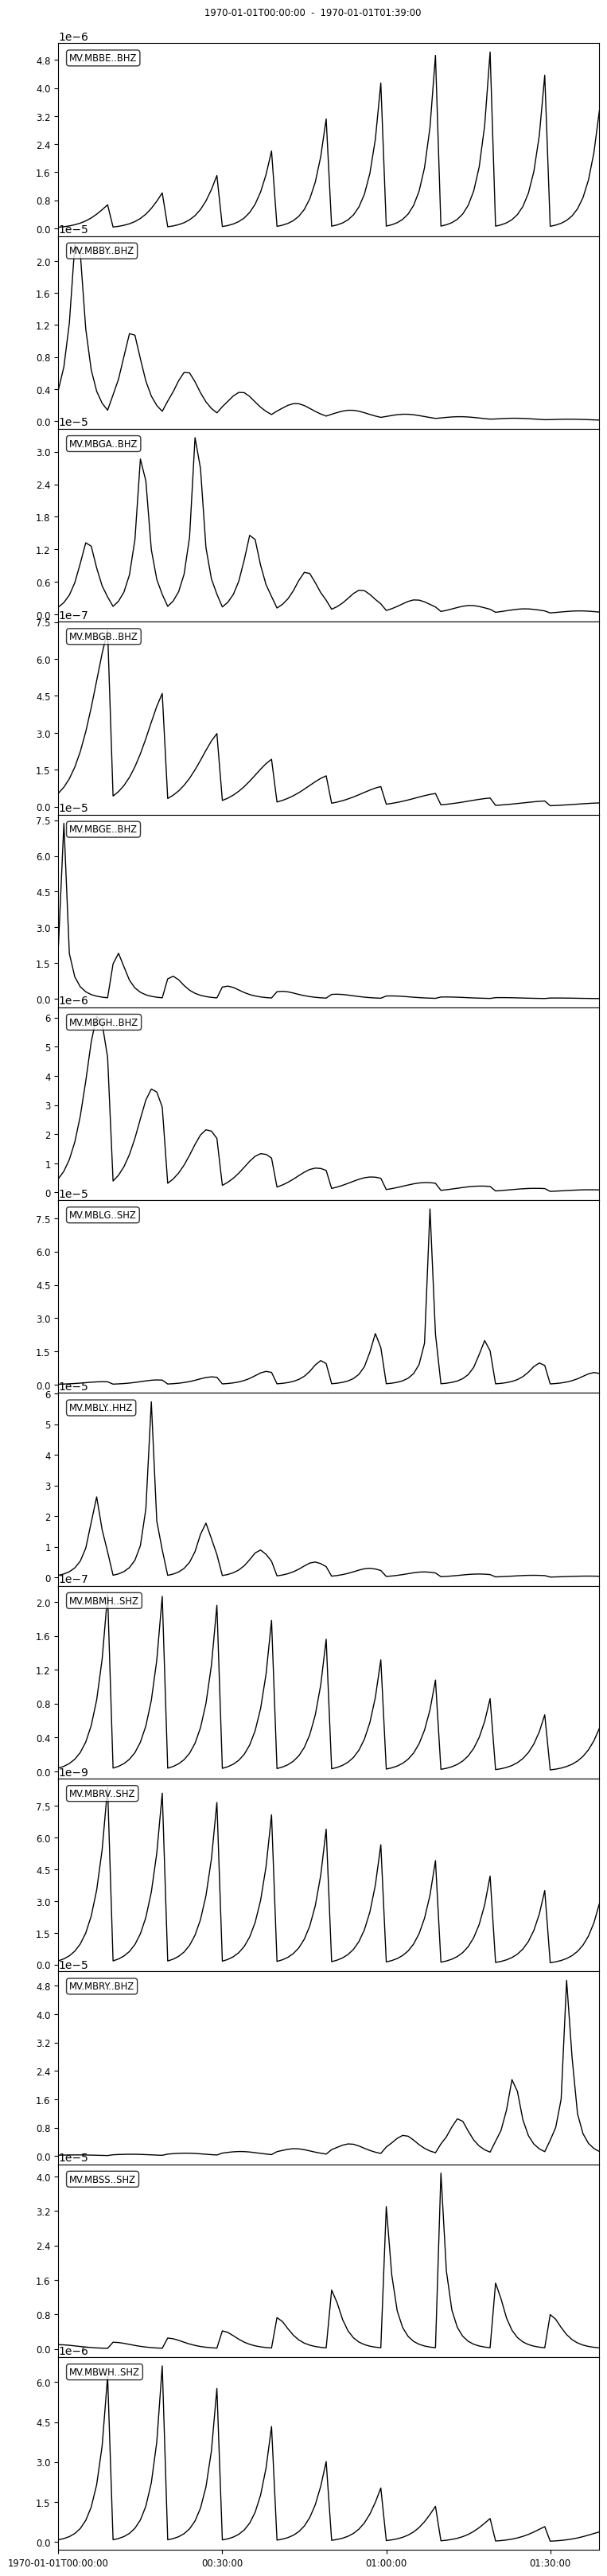

In [3]:
sampling_interval = 60
synthetic_source = {}
N = 10
synthetic_source['lat'] = 16.69 + np.tile(np.arange(N)/200, N)
synthetic_source['lon'] = -62.20 + np.repeat(np.arange(N)/200, N)
synthetic_source['DR'] = np.ones(N*N) * 100.0 # 100 cm^2 everywhere
synthetic_source['t'] = [obspy.UTCDateTime(0) + t * sampling_interval for t in range(N*N)]
#print(synthetic_source)

surfaceWaveSpeed_kms = 1.5
peakf=8.0
Q=23
synthDSAMobj = simulate_DSAM(invMVO, synthetic_source, surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, \
                             peakf=peakf, Q=Q, noise_level_percent=0.0)
synthDSAMobj.plot(metrics='mean')

### 2.3 Create grid with 100-m node spacing, 8 x 10 km 

-62.260527595207385 -62.093472404792614 16.631 16.790999999999997
Loading EarthReliefData-62.177.16.711.0.03s.pkl
Making color pallet
Calling grdimage


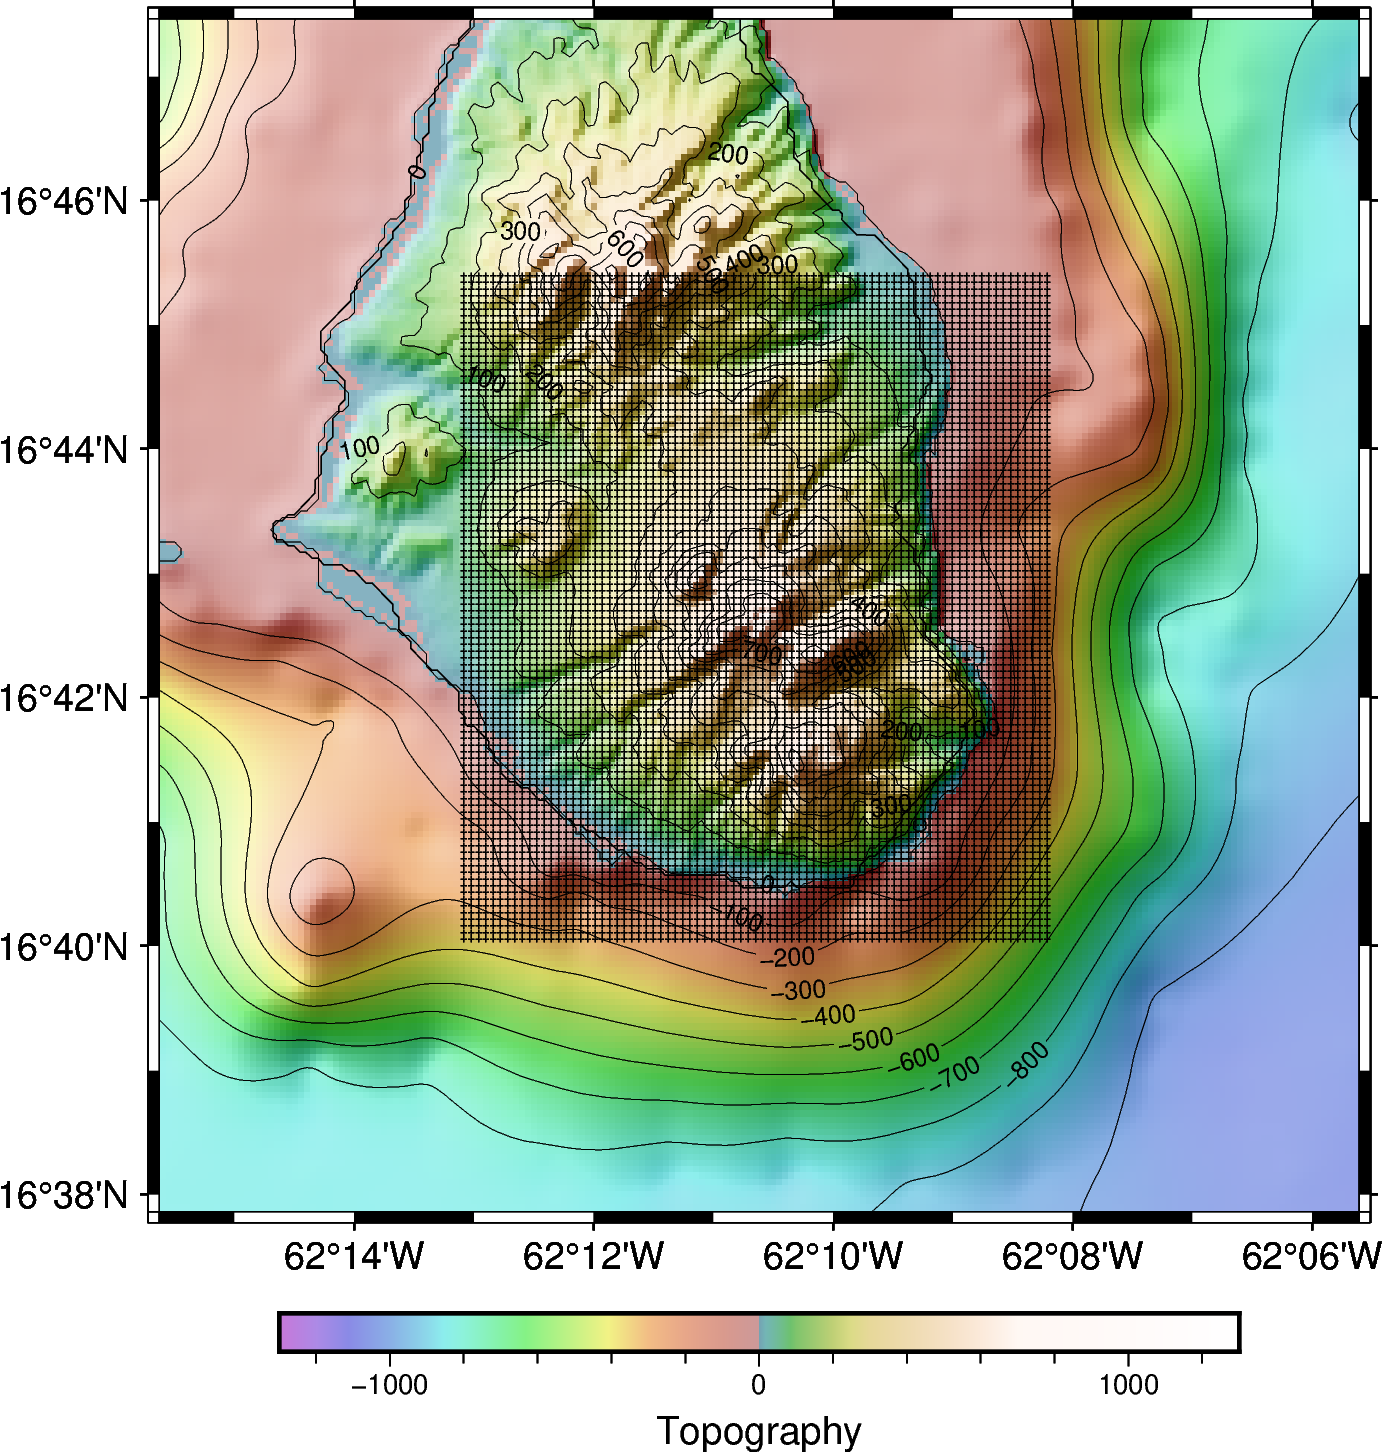

In [4]:
node_spacing_m = 100
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(np.mean(synthetic_source['lat']), np.mean(synthetic_source['lon']), nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

### 2.4 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

-62.21876379760369 -62.13523620239631 16.671 16.750999999999998
Loading EarthReliefData-62.177.16.711.1.03s.pkl
Making color pallet
Calling grdimage


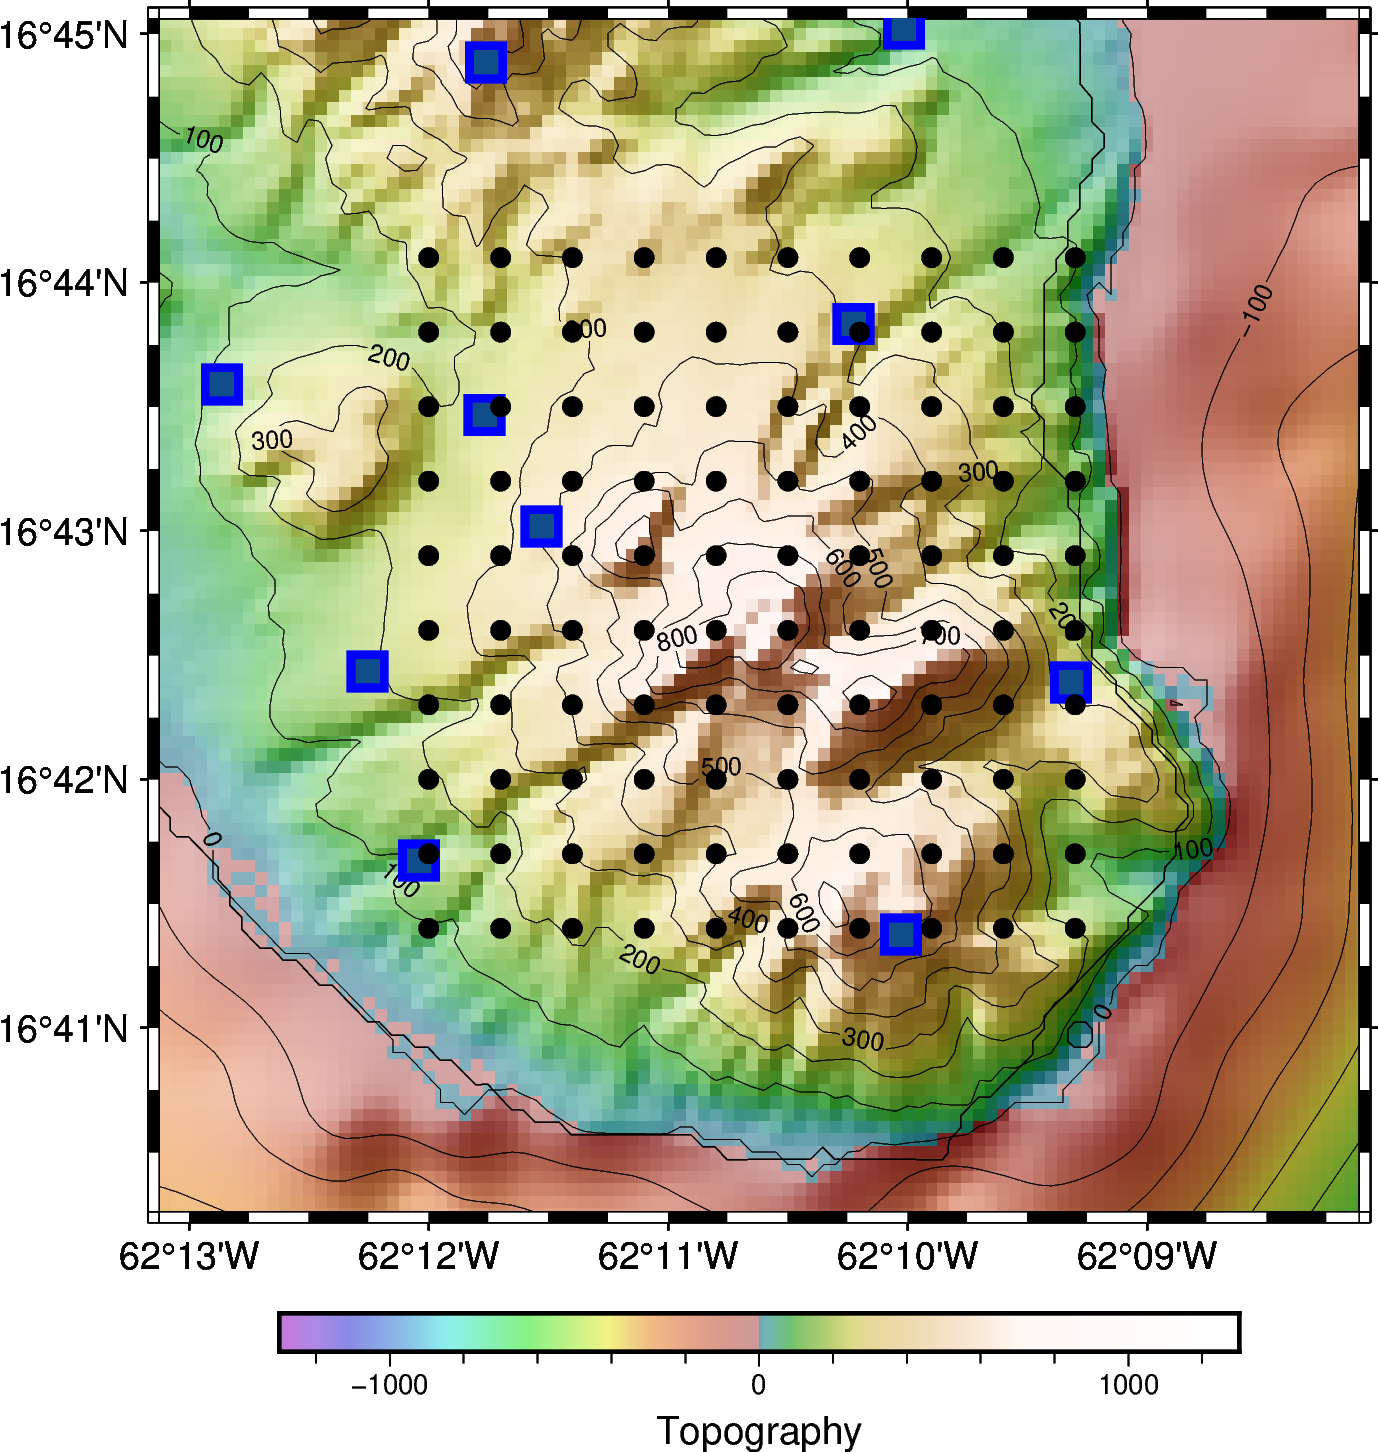

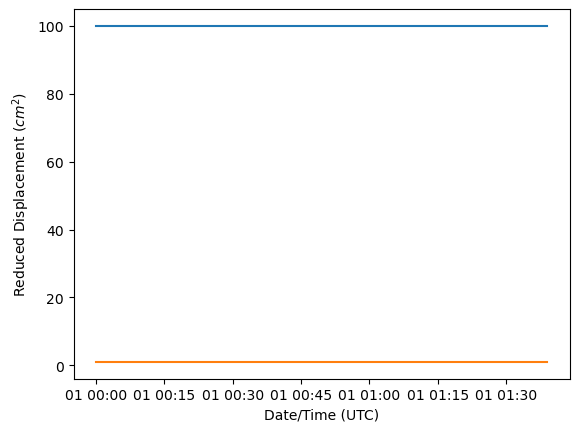

In [5]:
aslobj = ASL(synthDSAMobj, 'mean', invMVO, gridobj)

aslobj.plot(synthetic_source, zoom_level=1, threshold_DR=1.0, scale=0.1)

### 2.5 Run location algorithm on synthetic source and plot resulting locations and DR time series

Location algorithm took 66.1542501449585 s
-62.21876379760369 -62.13523620239631 16.671 16.750999999999998
Loading EarthReliefData-62.177.16.711.1.03s.pkl
Making color pallet
Calling grdimage


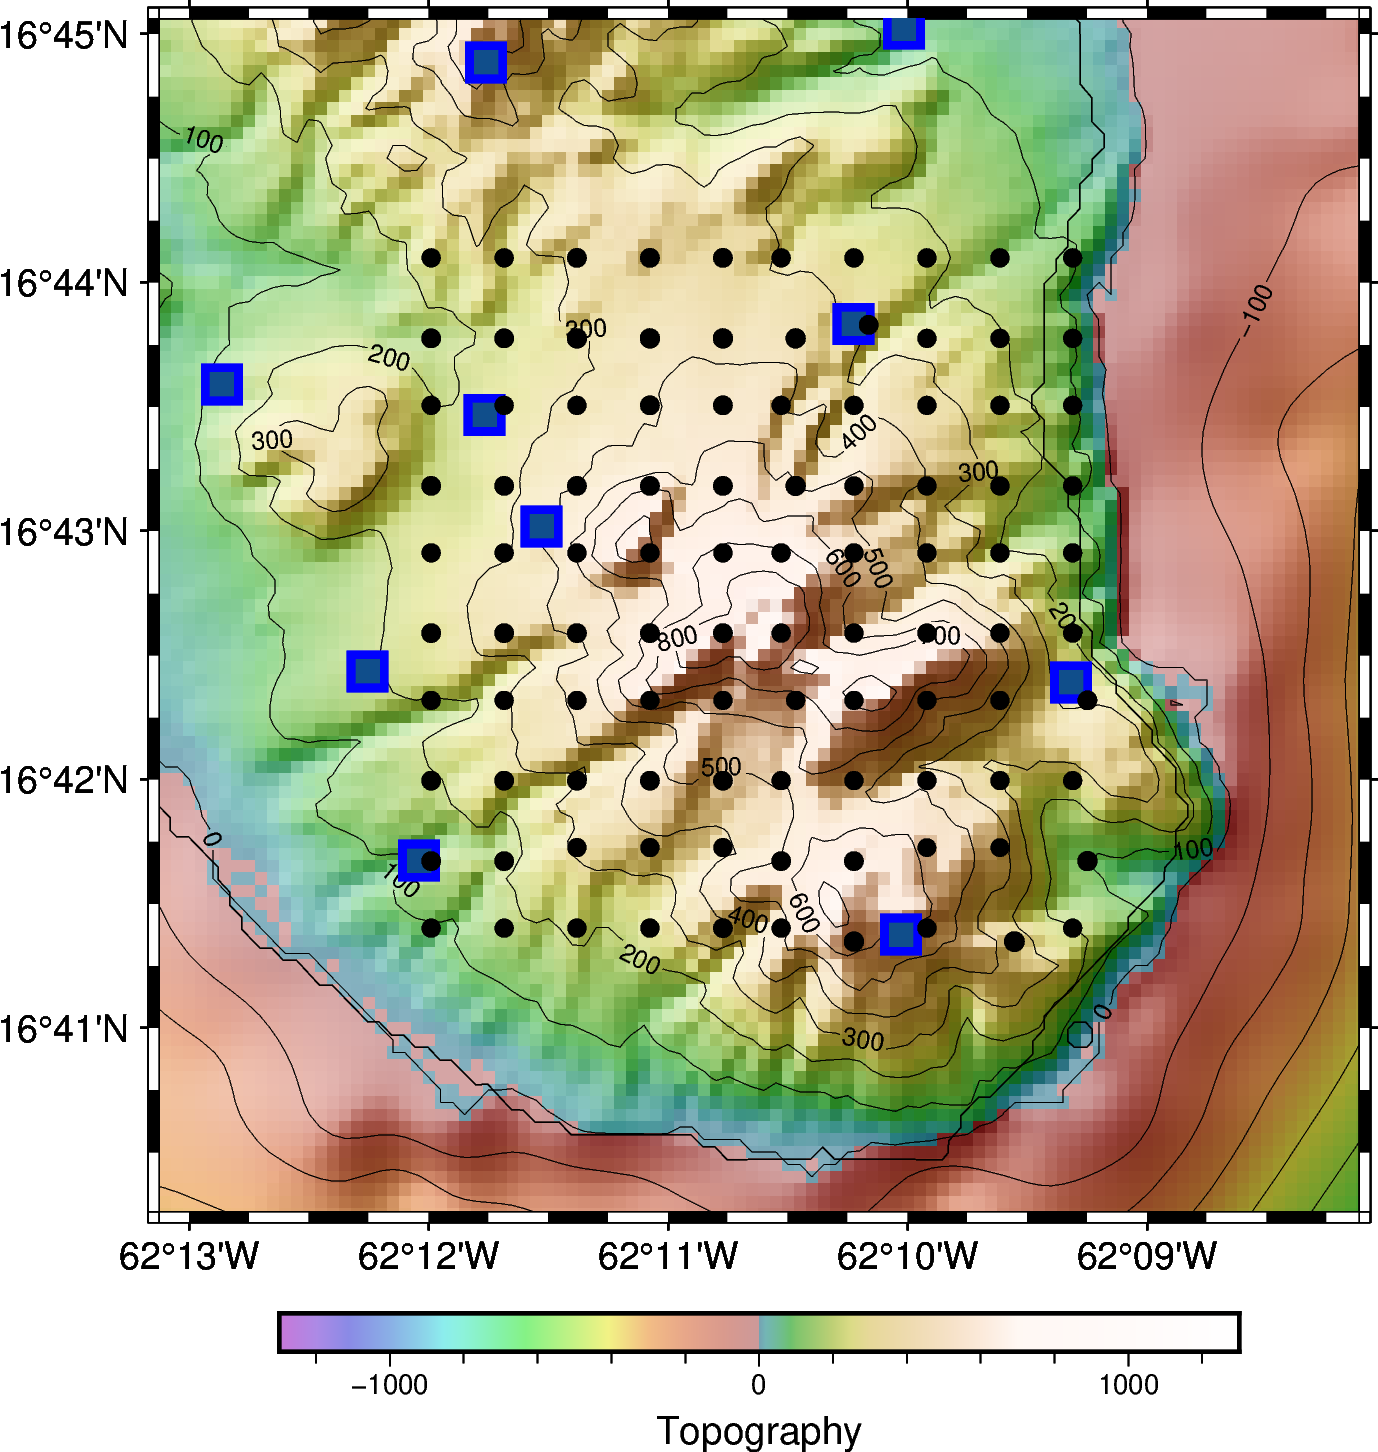

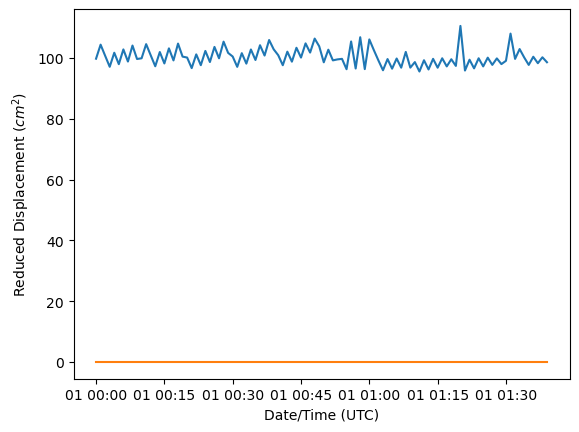

In [6]:
import time
aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf=peakf)

time1 = time.time()
source = aslobj.locate()
time2 = time.time()
print(f'Location algorithm took {time2-time1} s')
aslobj.plot(source, zoom_level=1, scale=0.1, threshold_DR=0.0)

Vectorized location algorithm took 0.12140035629272461 s
-62.21876379760369 -62.13523620239631 16.671 16.750999999999998
Loading EarthReliefData-62.177.16.711.1.03s.pkl
Making color pallet
Calling grdimage


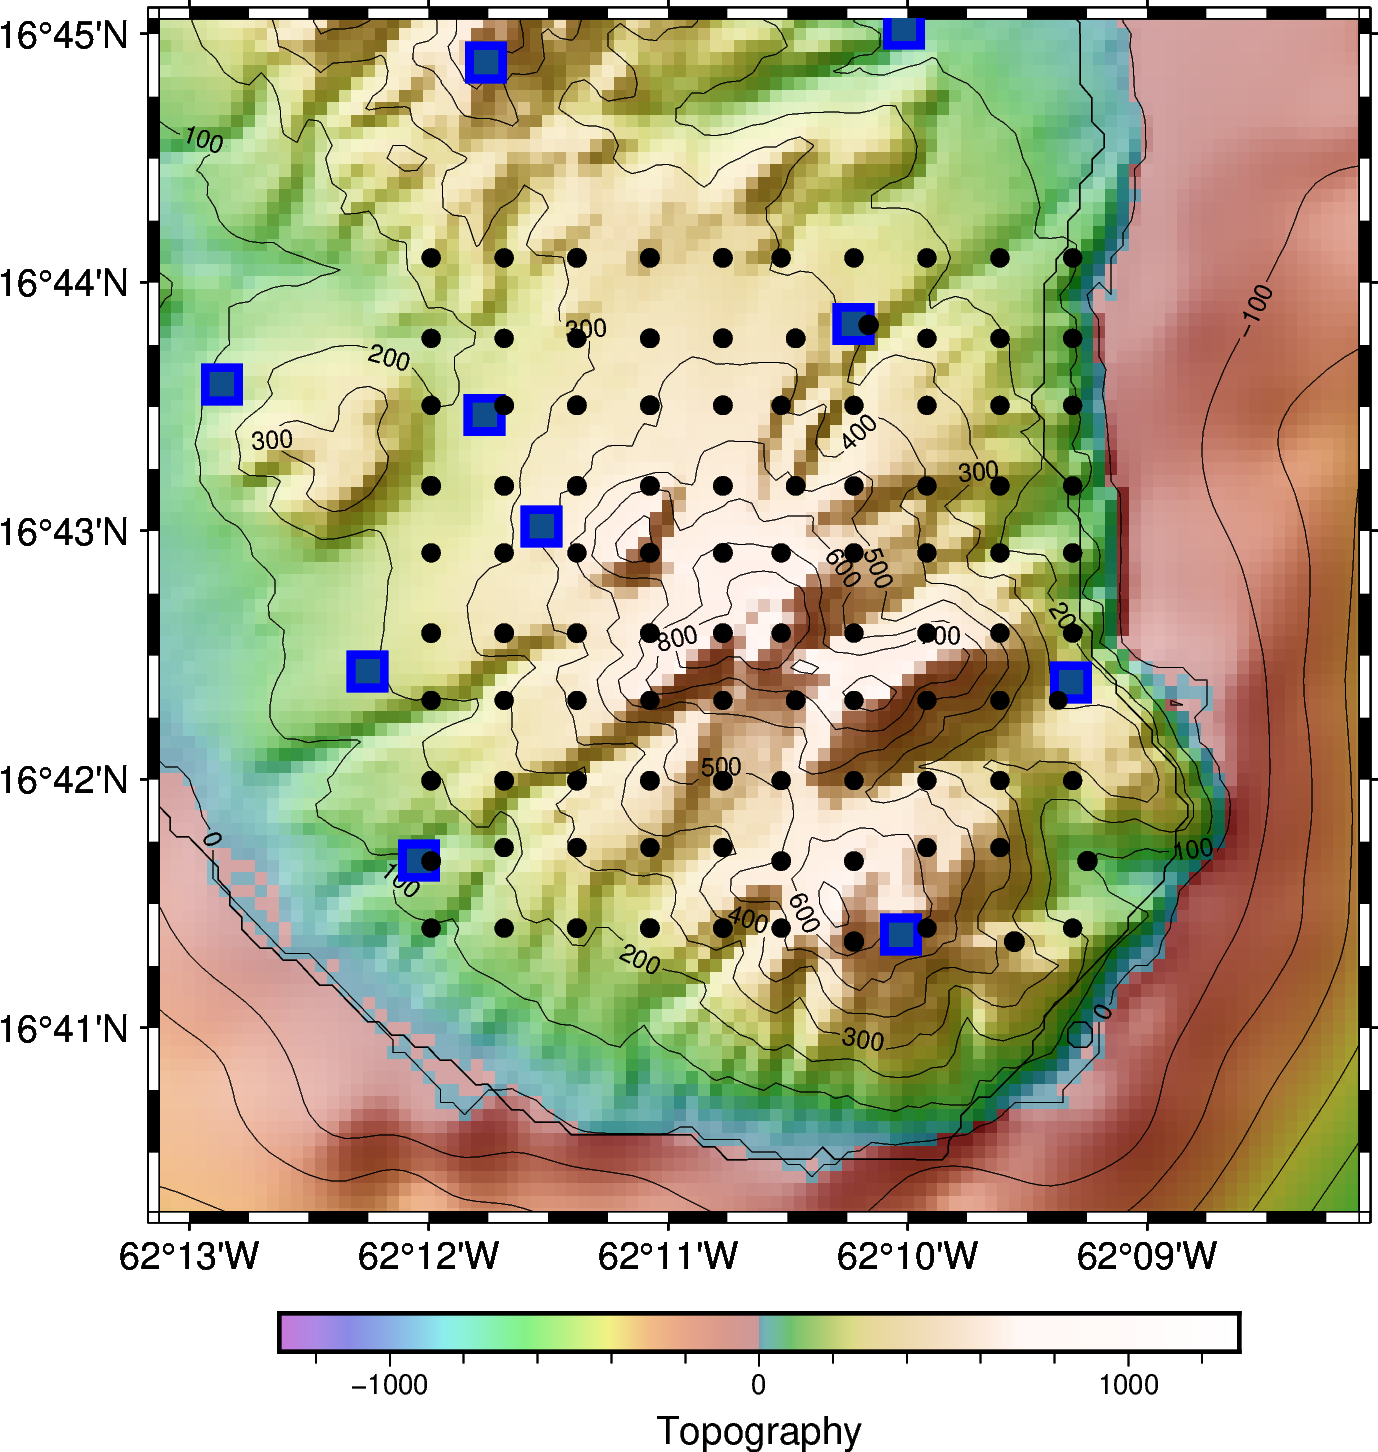

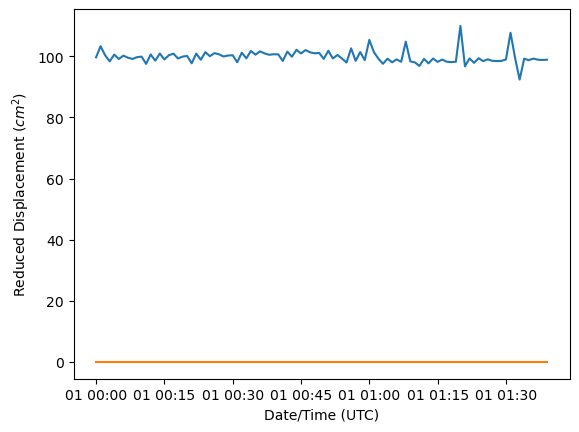

In [7]:
time1 = time.time()
fast_source = aslobj.fast_locate()
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj.plot(fast_source, zoom_level=1, scale=0.1, threshold_DR=0.0)

## 3 Locating real DSAM data: July 12, 2003 collapse

Now we are confident in our ability to locate synthetic data correctly, and determine reduced displacement correctly, we will try to locate some real data. In this example, we use the 'VT' metric from the DSAM dataset. Recall that this is the mean amplitude of the signal (over 60-s time windows) after filtering between 4 and 18 Hz, rather than the 'mean' metric (or 'median', or 'rms' etc.) which are computed on signals filtered between 0.5 and 18 Hz. We do this because Jolly et al. (2002) determined that a 7-9 Hz bandpass was best for locating pyroclastic flows, and so the VT band is the one we have available that best matches this.

### 3.1 Read inventory and DSAM data. Plot DSAM data

METRIC:  VT


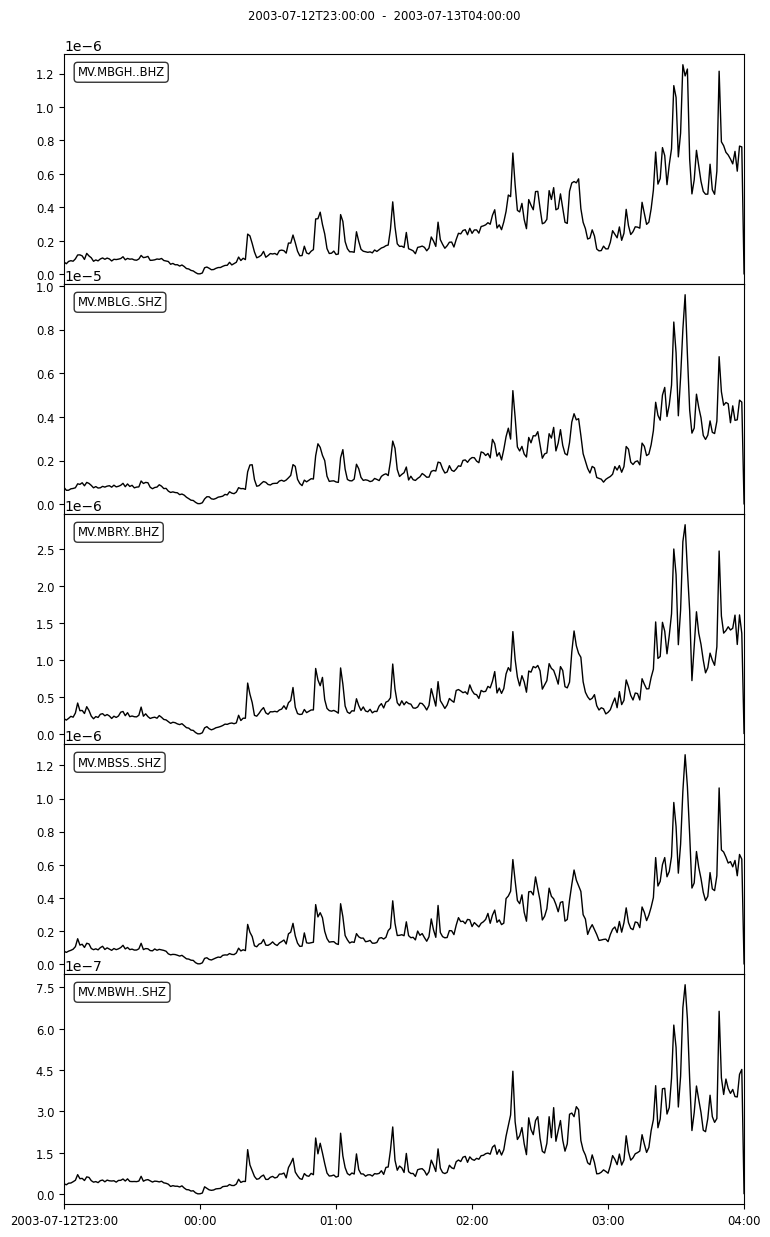

In [8]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])  

dsamObj.plot(metrics='VT')

### 3.2 Create dense grid (20-m node spacing) and plot

-62.260527595207385 -62.093472404792614 16.631 16.790999999999997
Loading EarthReliefData-62.177.16.711.0.03s.pkl
Making color pallet
Calling grdimage


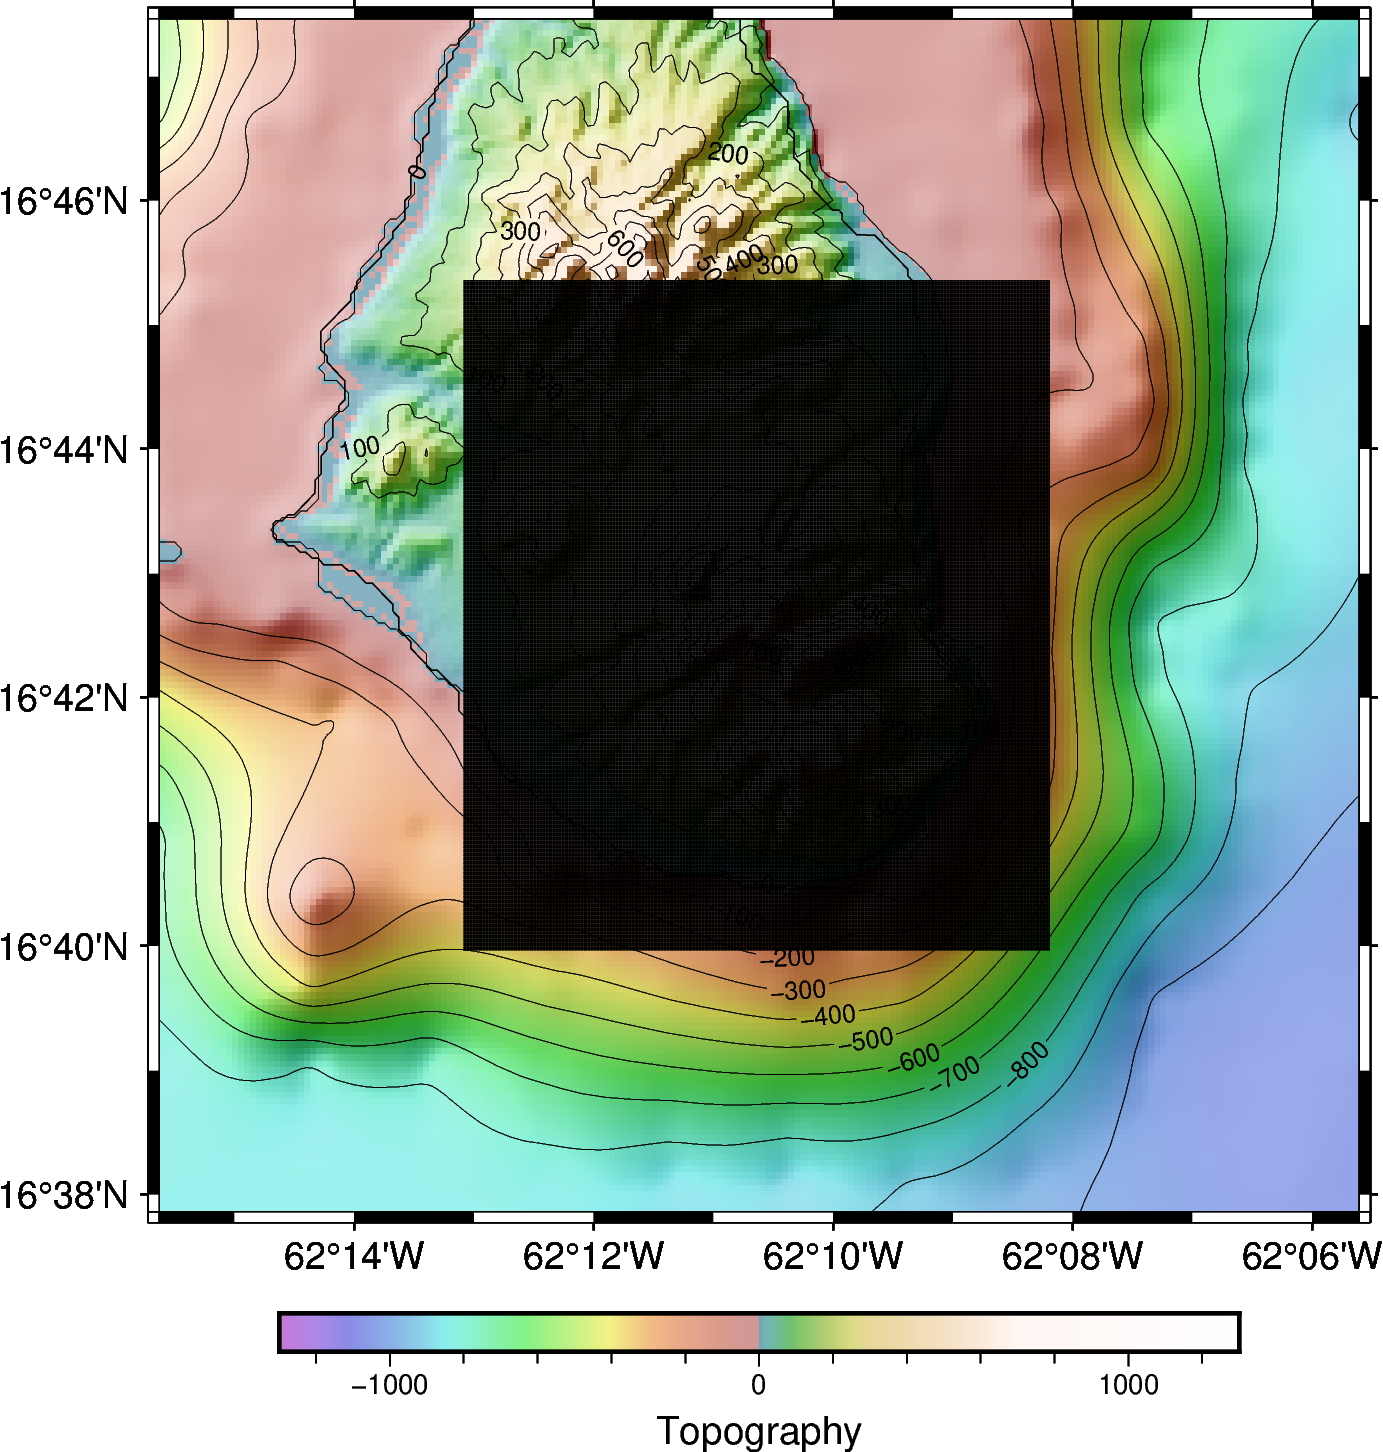

In [9]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 20
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

### 3.3 Create ASL object, compute combined geometrical spreading and inelatic attenuation corrections for each node

In [10]:
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

aslobj = ASL(dsamObj, 'rms', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf)

### 3.4 Run the amplitude location

In [11]:
source = aslobj.fast_locate()

### 3.5 Plot sources and source reduced displacements

-62.197881898801846 -62.15611810119815 16.691 16.730999999999998
Loading EarthReliefData-62.177.16.711.2.03s.pkl
Making color pallet
Calling grdimage


/home/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


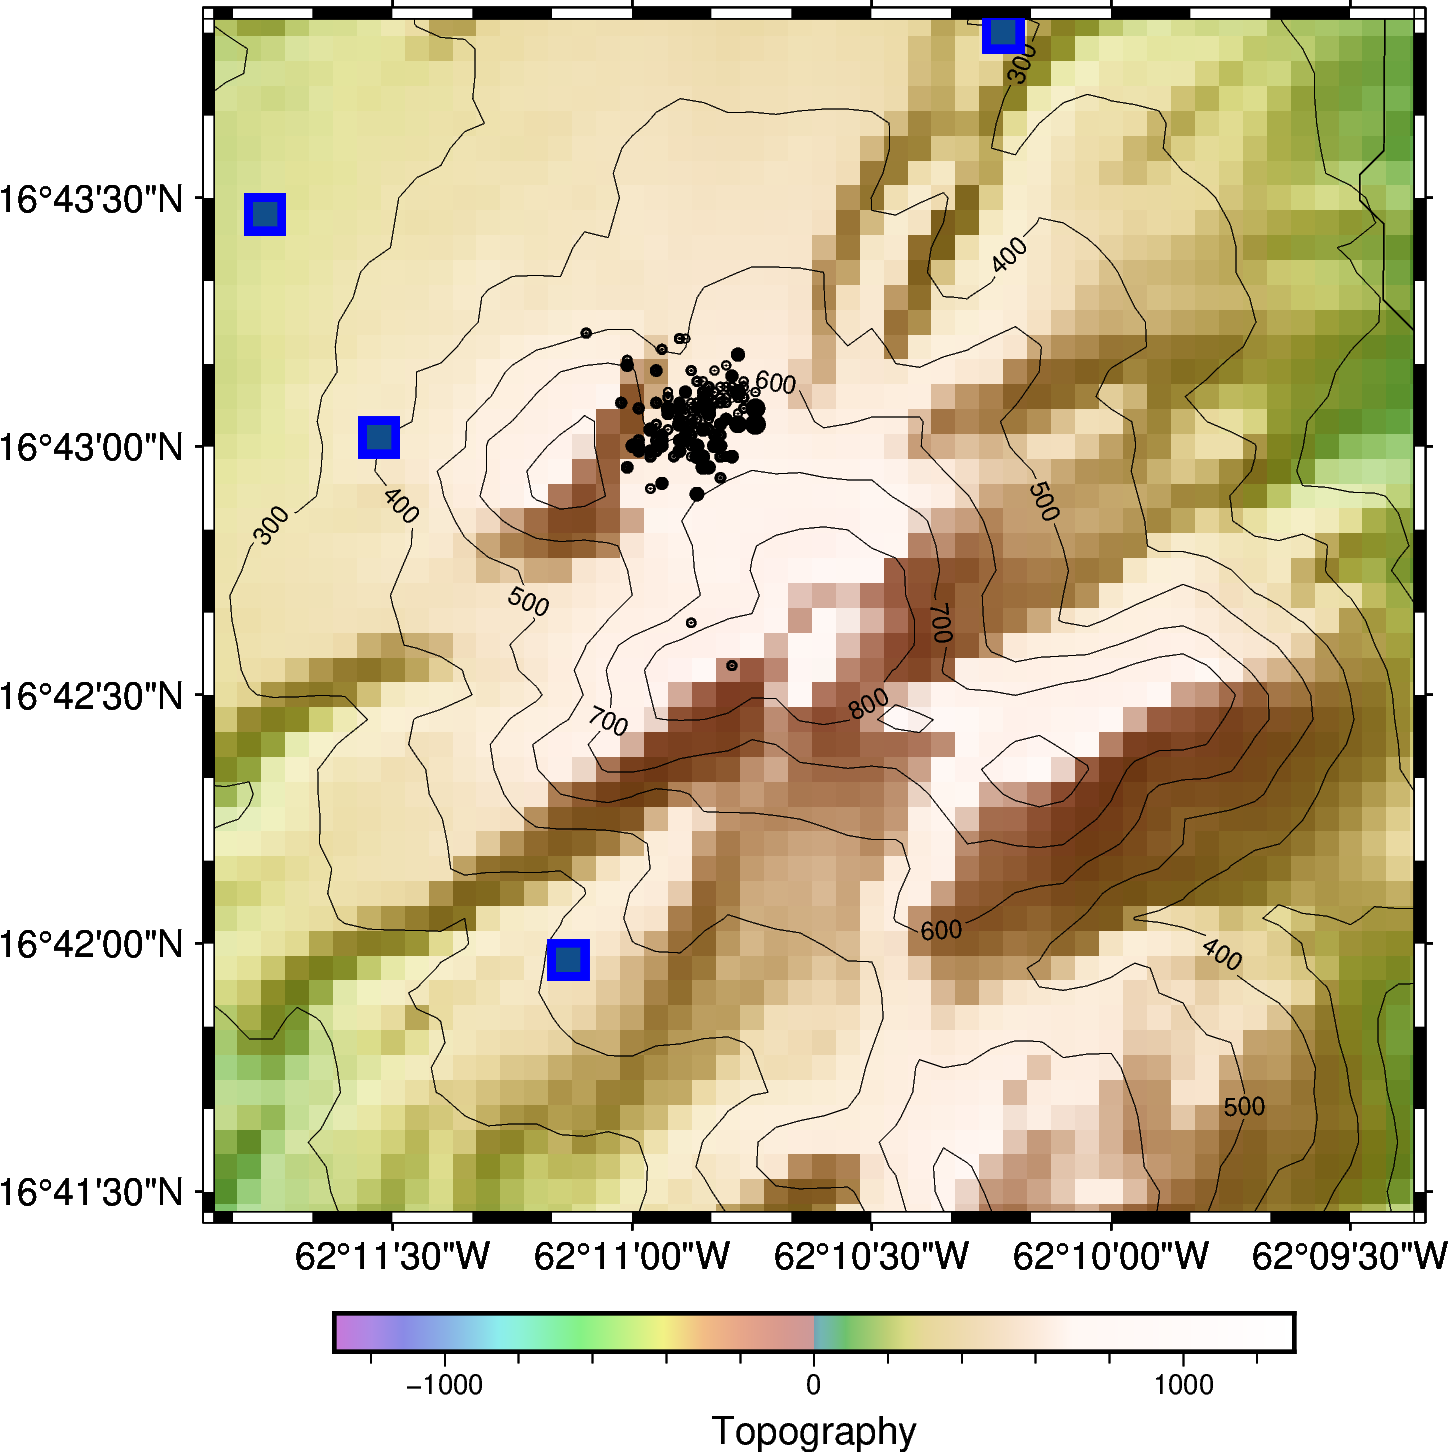

-62.260527595207385 -62.093472404792614 16.631 16.790999999999997
Loading EarthReliefData-62.177.16.711.0.03s.pkl
Making color pallet
Calling grdimage


/home/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


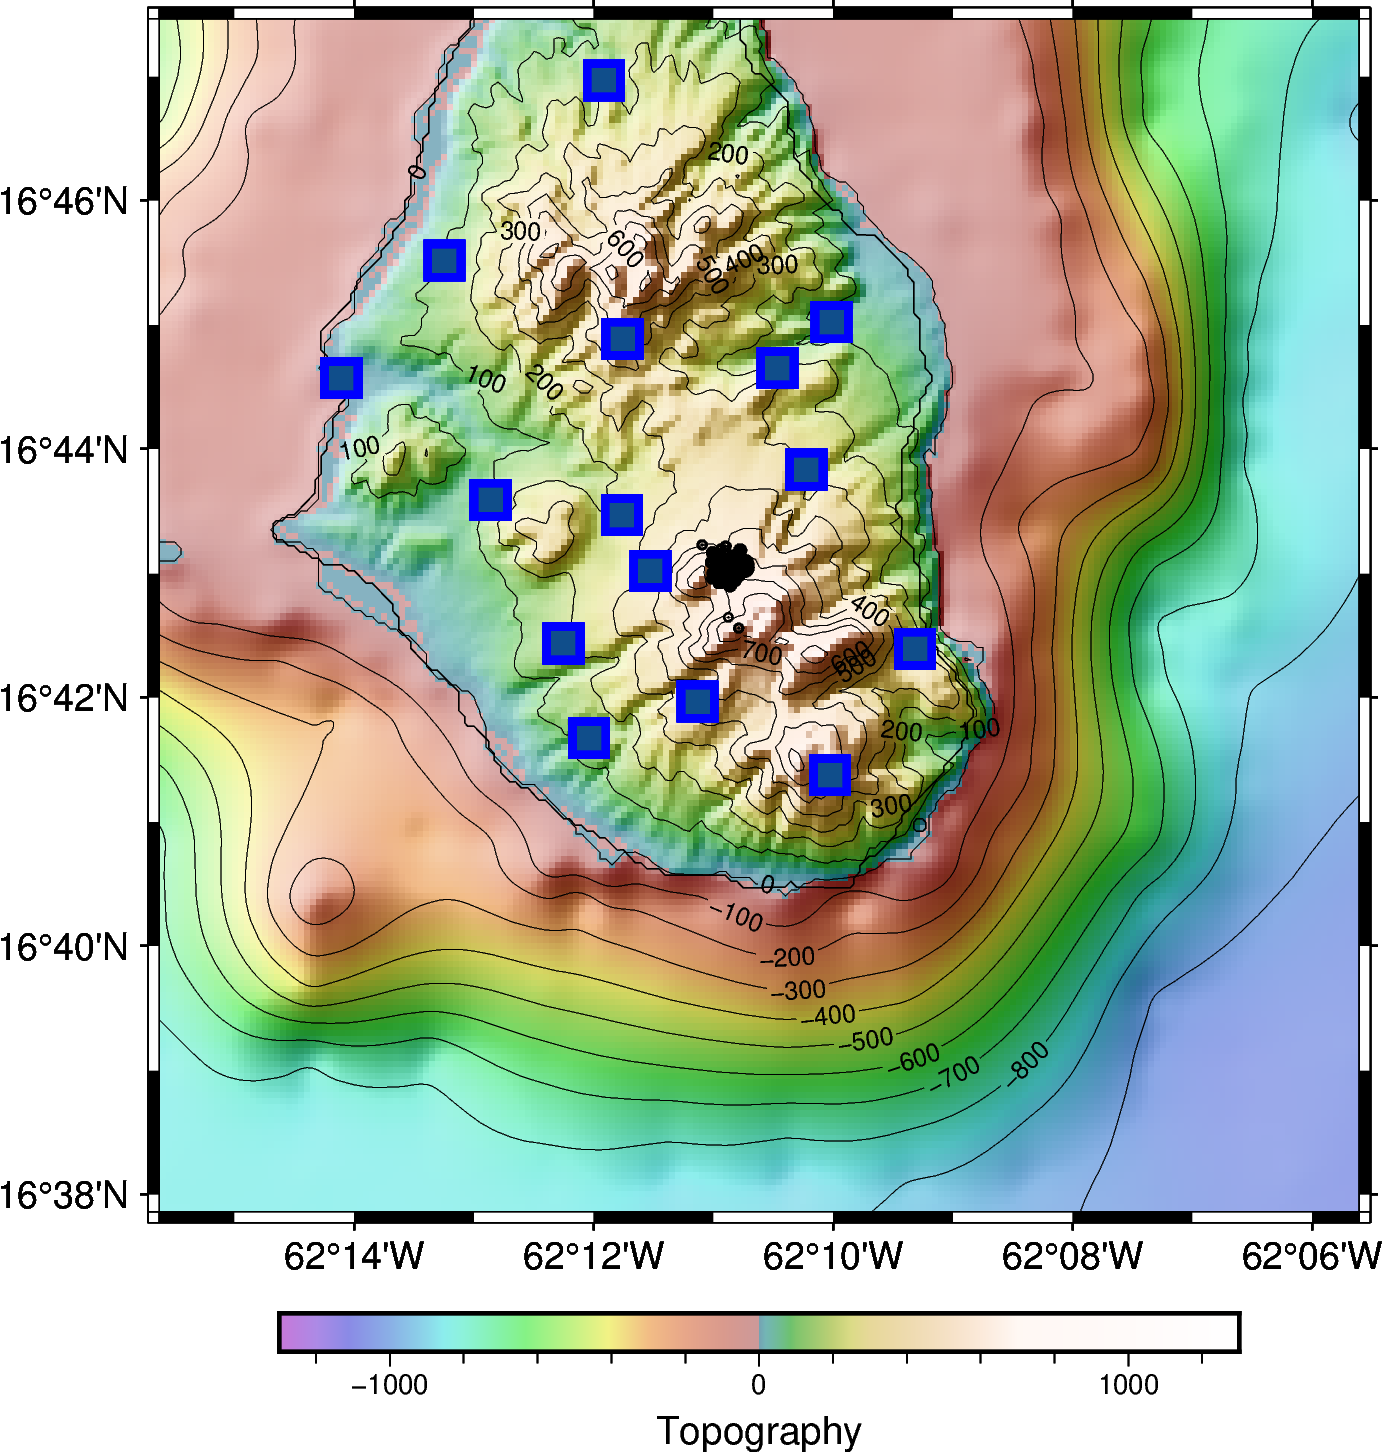

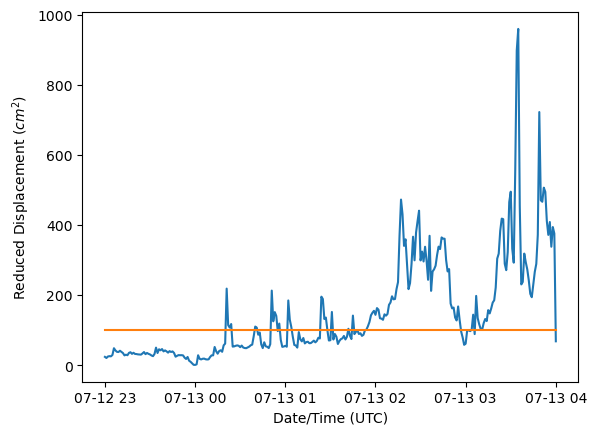

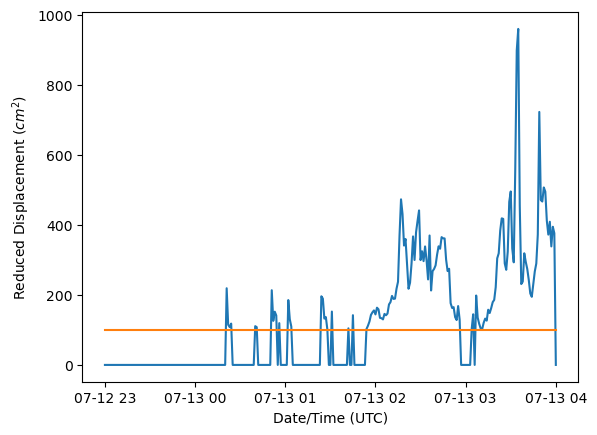

In [12]:
aslobj.plot(source, zoom_level=2, threshold_DR=100.0, scale=0.1)
aslobj.plot(source, zoom_level=0, threshold_DR=100.0, scale=0.1)

## 4. Locate a pyroclastic flow

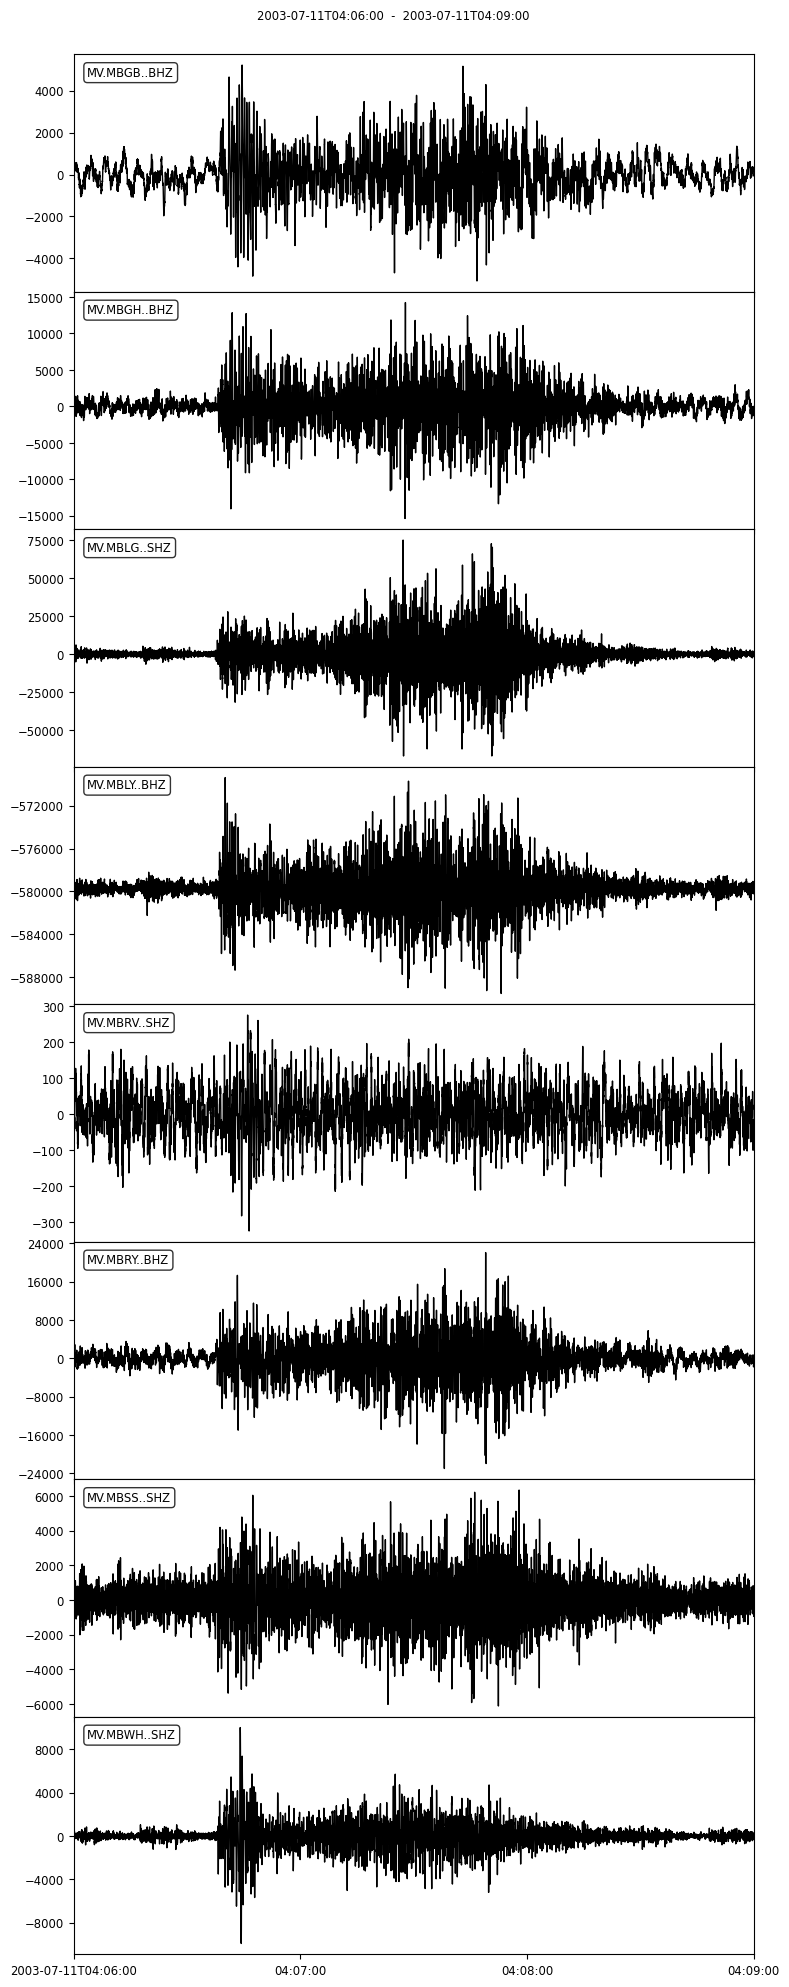

MV.MBGB..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBGH..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBLG..SHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBLY..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 100.0 Hz, 18001 samples
MV.MBRV..SHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBRY..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBSS..SHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBWH..SHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
            time           min          mean           max        median  \
0   1.057896e+09  1.459870e-10  3.070572e-08  1.180026e-07  2.198195e-08   
1   1.057896e+09  4.883328e-10  3.909828e-08  1.150951e-07  3.5

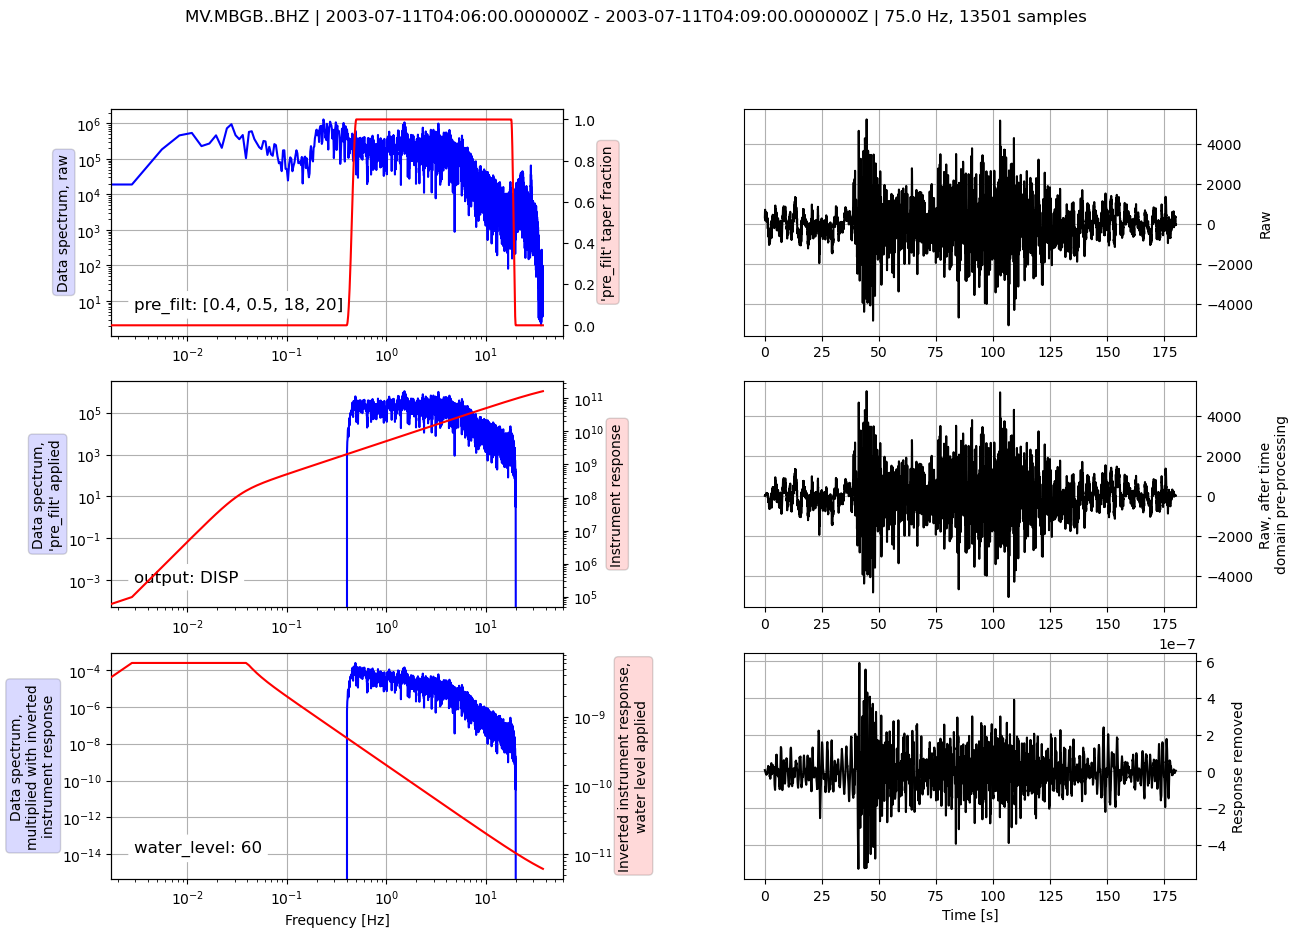

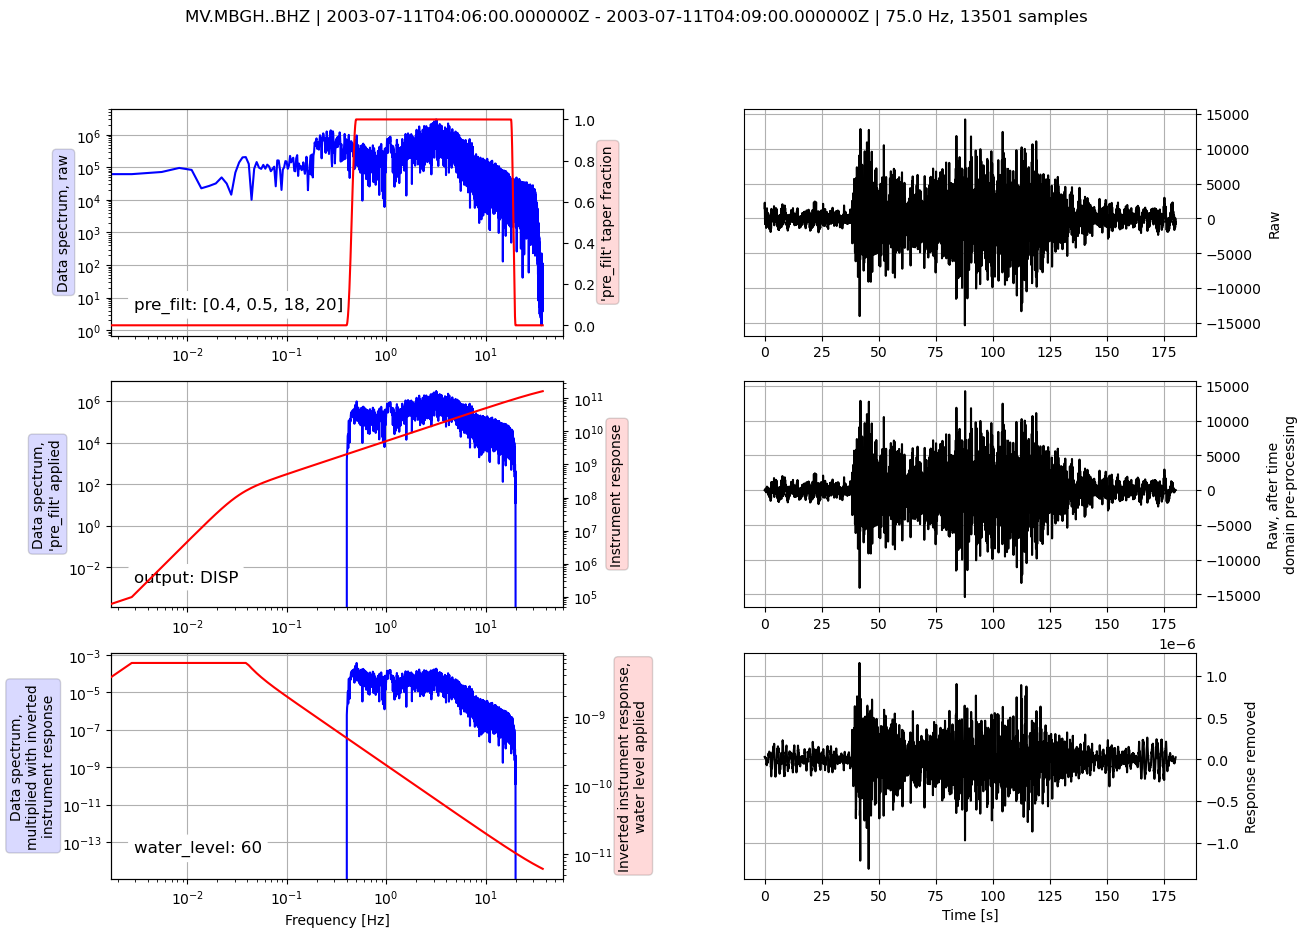

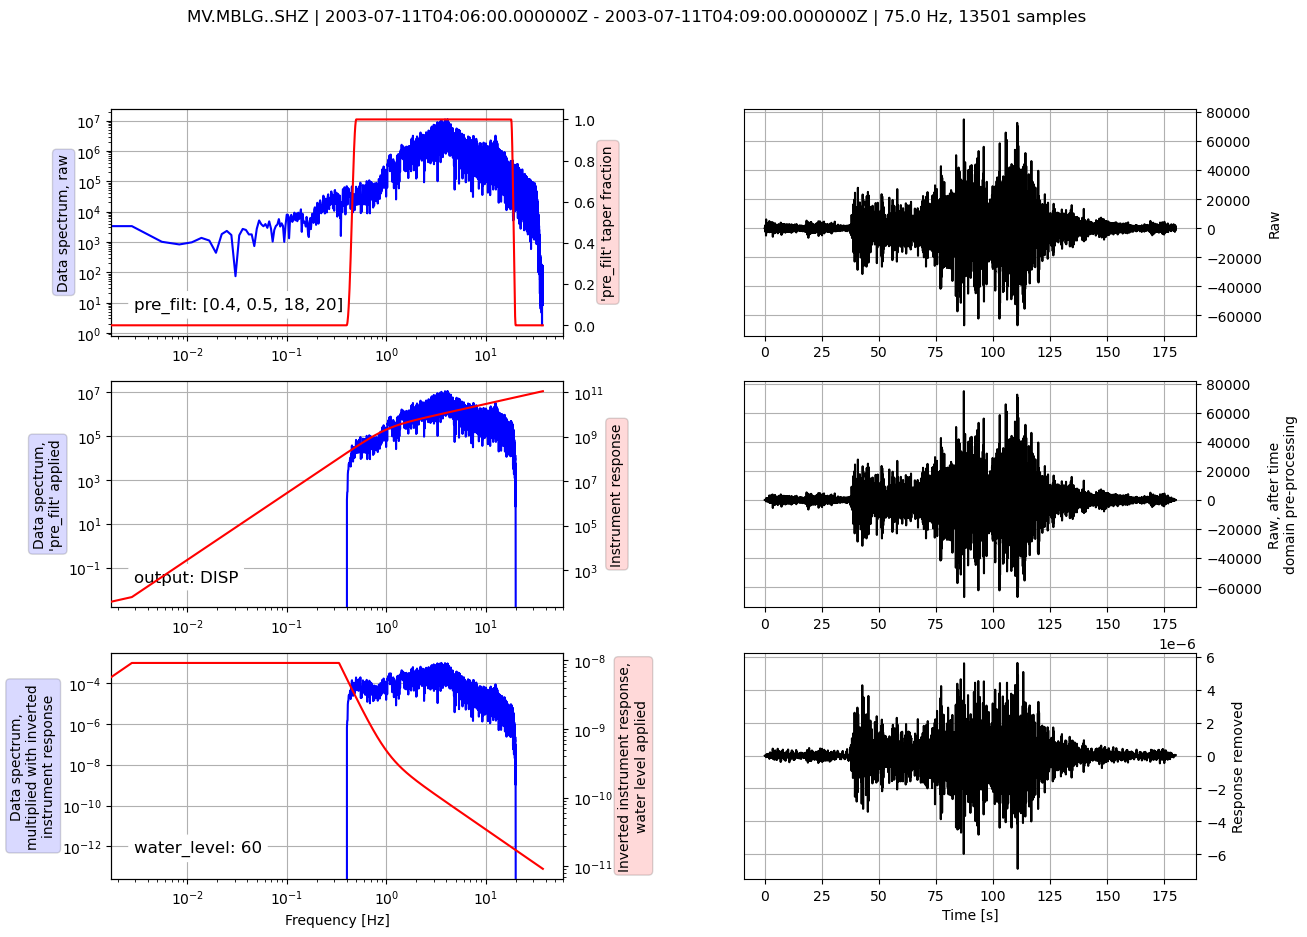

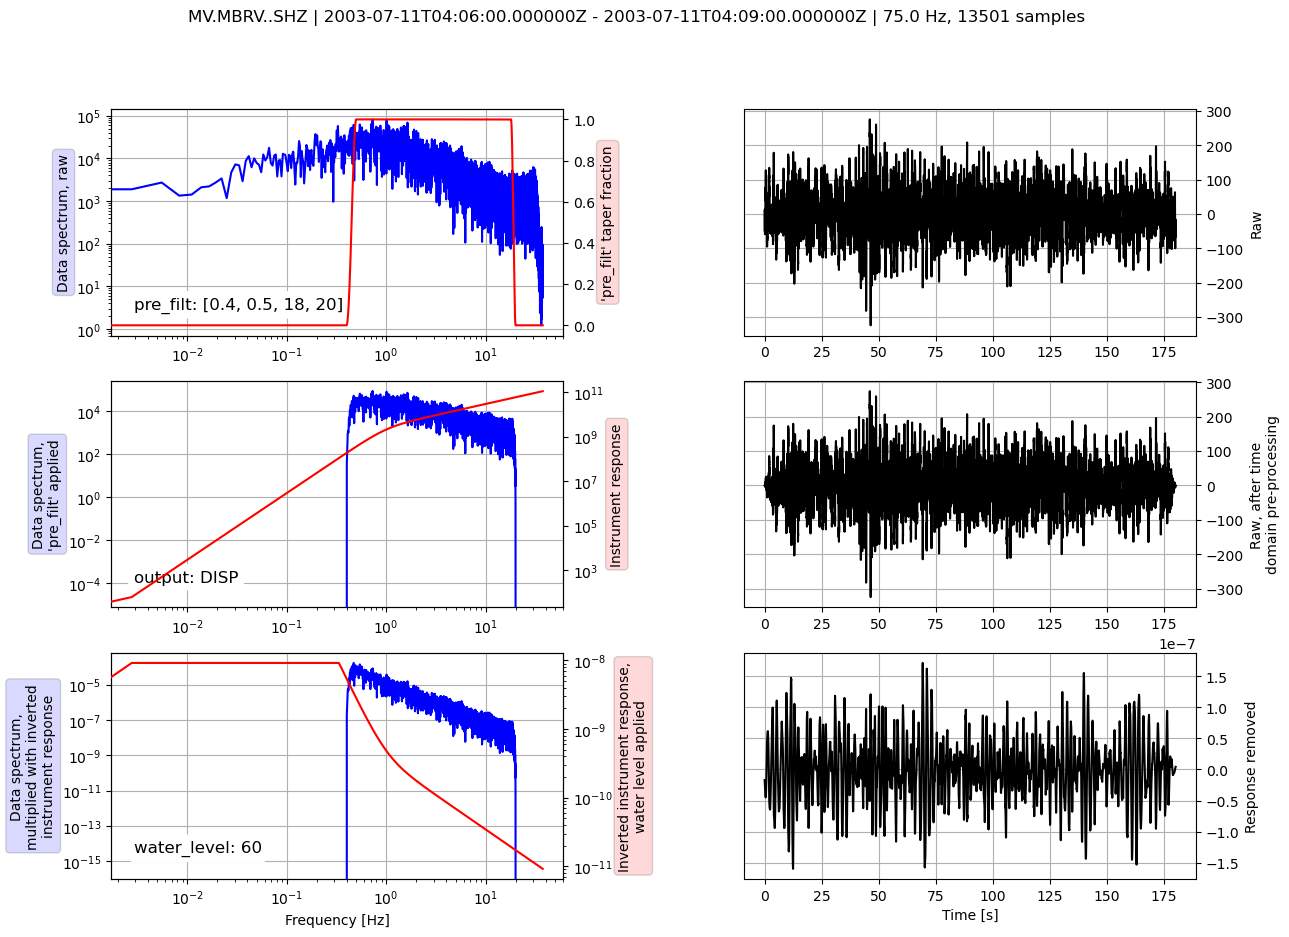

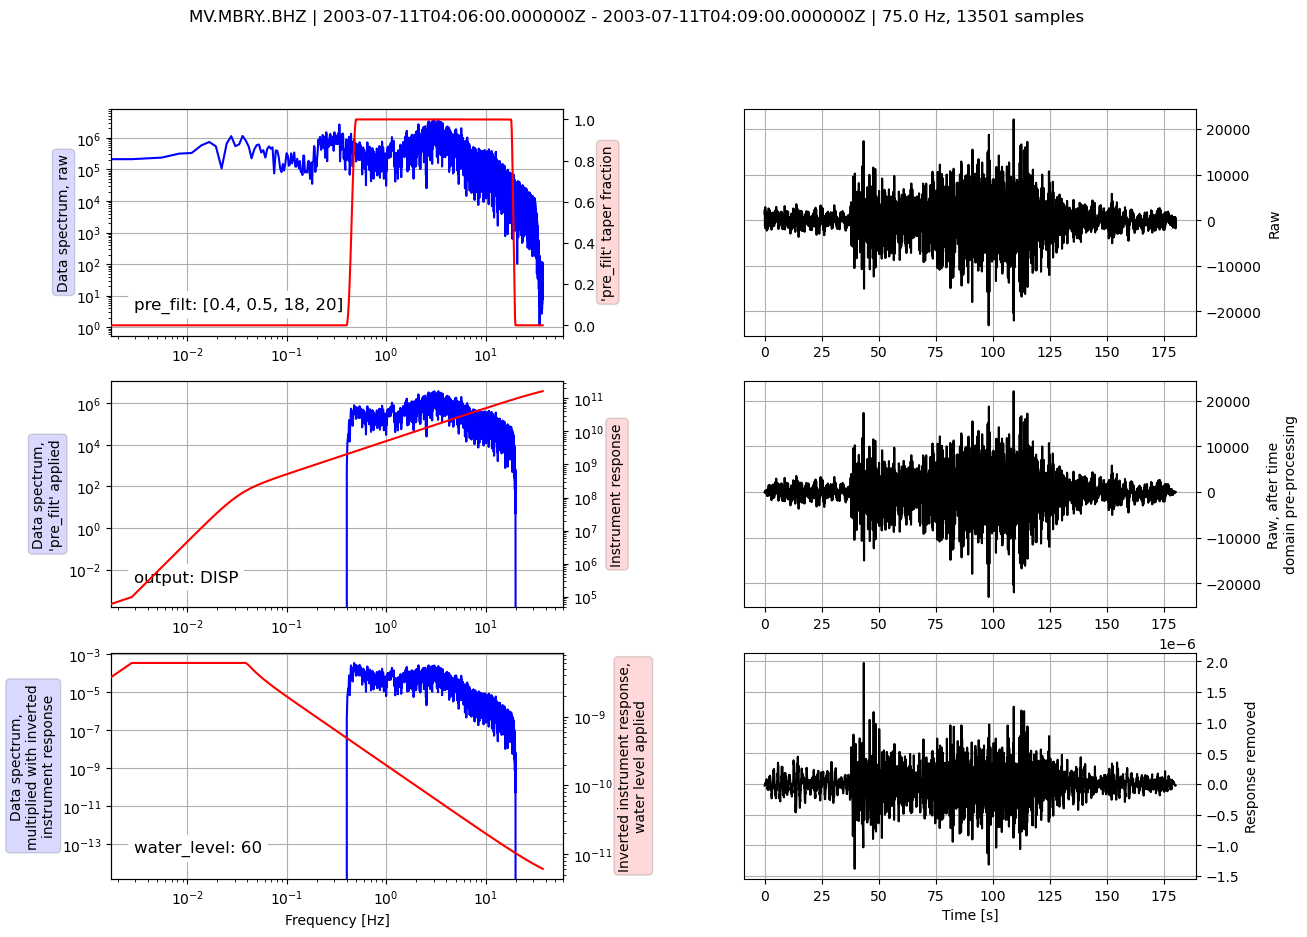

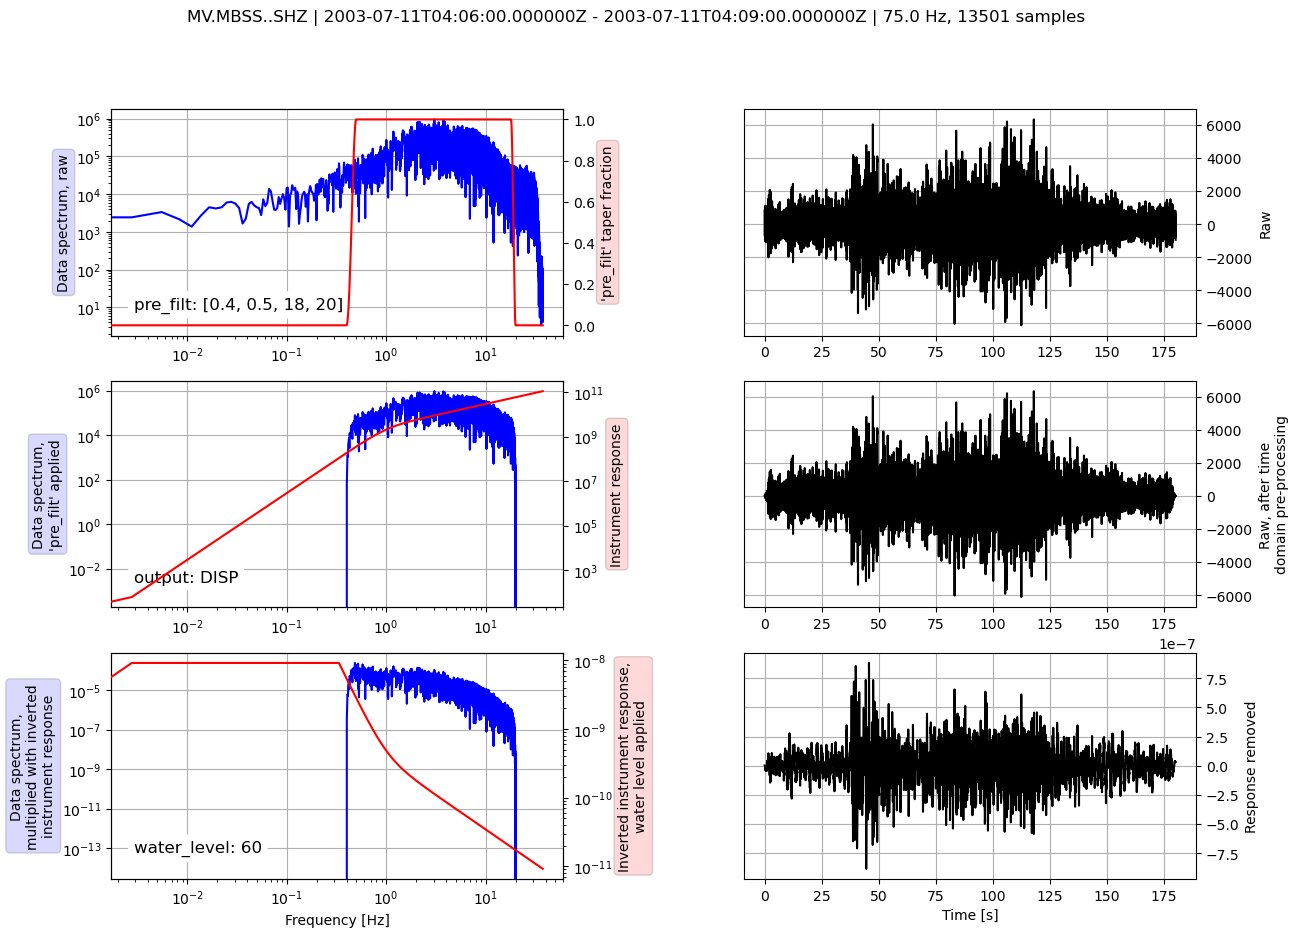

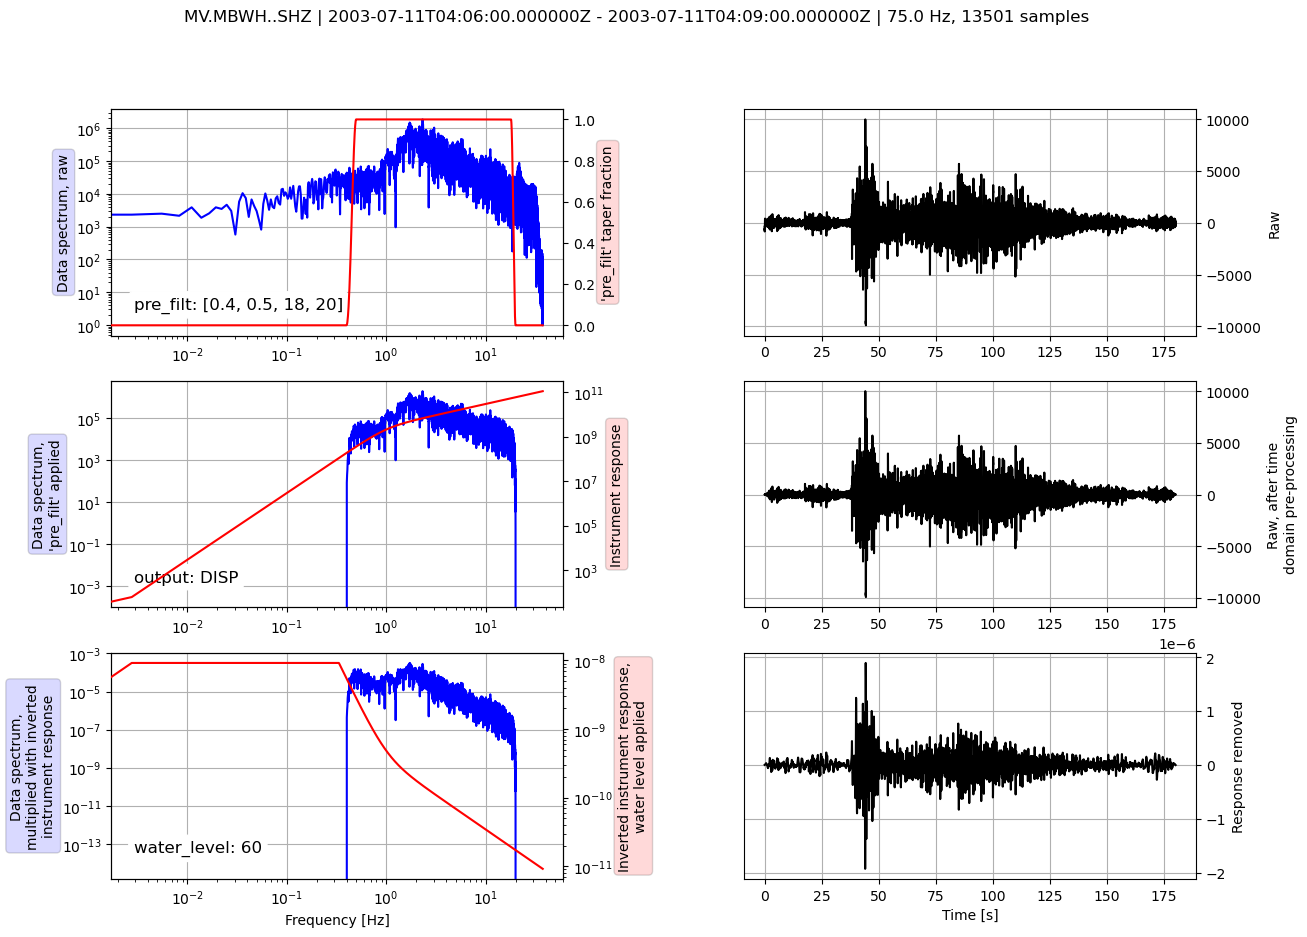

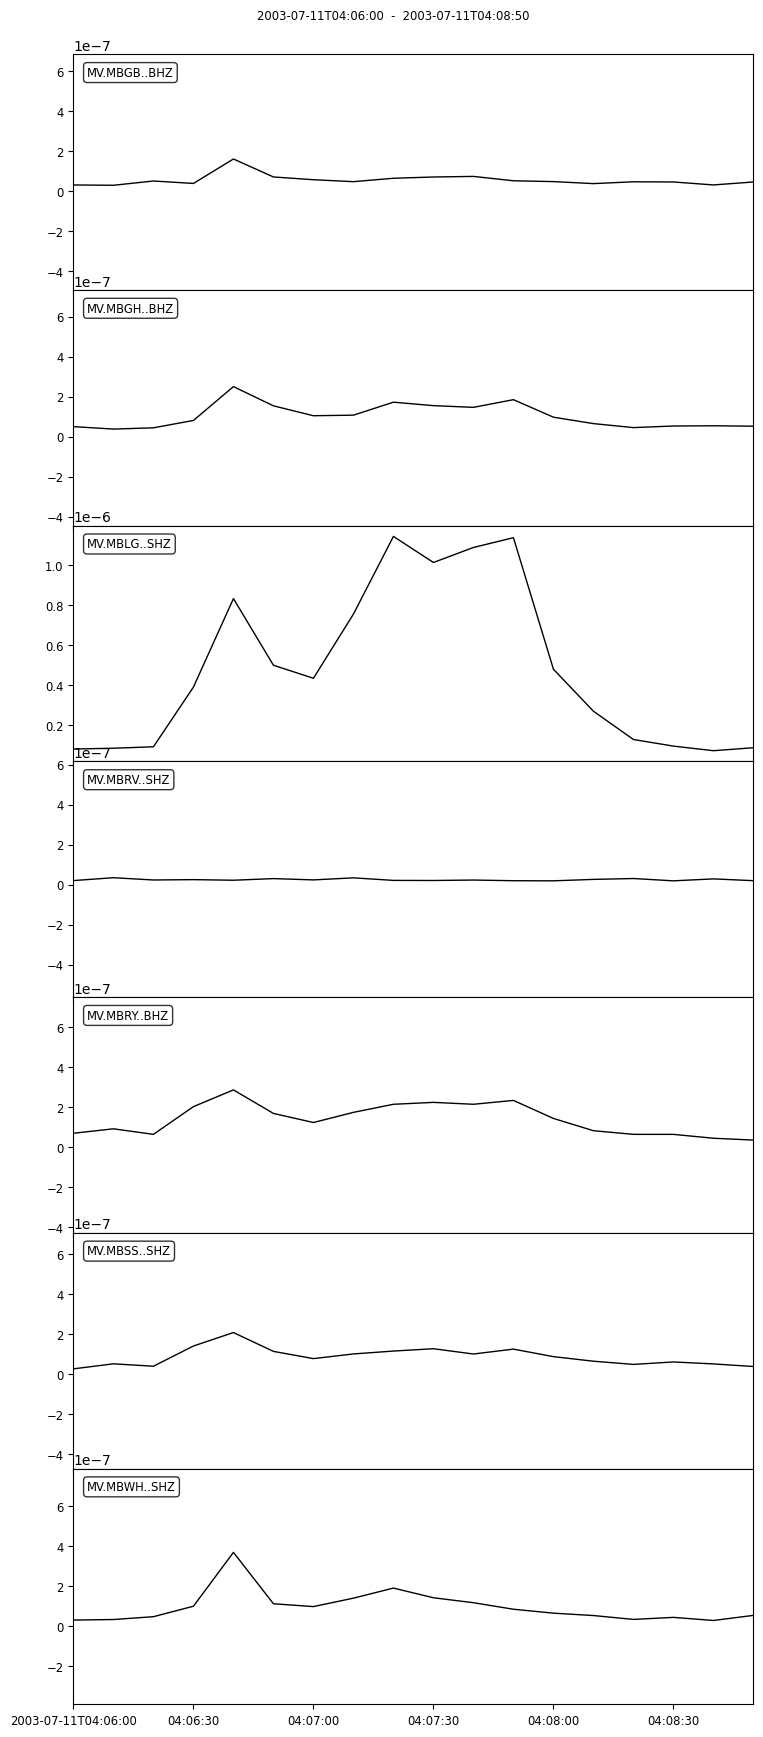

In [13]:
import os
import sys
import numpy as np
import time
import obspy
from obspy import read_inventory
sys.path.append('../lib')
from SAM import DSAM
from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM
from obspy.clients.filesystem.sds import Client

sdsclient = Client(SDS_DIR)
st = sdsclient.get_waveforms("MV", "*", "", "*Z", obspy.UTCDateTime(2003, 7, 11, 4, 6, 0), obspy.UTCDateTime(2003, 7, 11, 4, 9, 0))
st.plot(equal_scale=False);

# same parameters as before
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

# same grid as before
source = {'lat':16.71111, 'lon':-62.17722}
#node_spacing_m = 20
node_spacing_m = 100
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

# Load inventory
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')

# remove instrument response - and set units accordingly IMPORTANT!
pre_filt = [0.4, 0.5, 18, 20]
#pre_filt = [6.0, 7.0, 9.0, 10.0]
for tr in st:
    print(tr)
    try:
        tr.remove_response(inventory=invMVO, pre_filt=pre_filt, output="DISP", plot=True) 
    except:
        st.remove(tr)
    else:
        tr.stats['units'] = 'm'
#st.plot(equal_scale=True);

# compute DSAM data with 10-s time window
dsamObj = DSAM(stream=st, sampling_interval=10)
print(dsamObj)
dsamObj.plot(metrics='rms', equal_scale=True)

seed_id   DRS
0  MV.MBGB..BHZ  0.81
1  MV.MBGH..BHZ  1.54
2  MV.MBLG..SHZ  9.79
3  MV.MBRV..SHZ  0.08
4  MV.MBRY..BHZ  1.68
5  MV.MBSS..SHZ  0.93
6  MV.MBWH..SHZ  0.95
7       Network  0.95

Maximum DRS assuming fixed source is: 0.95
METRIC:  mean


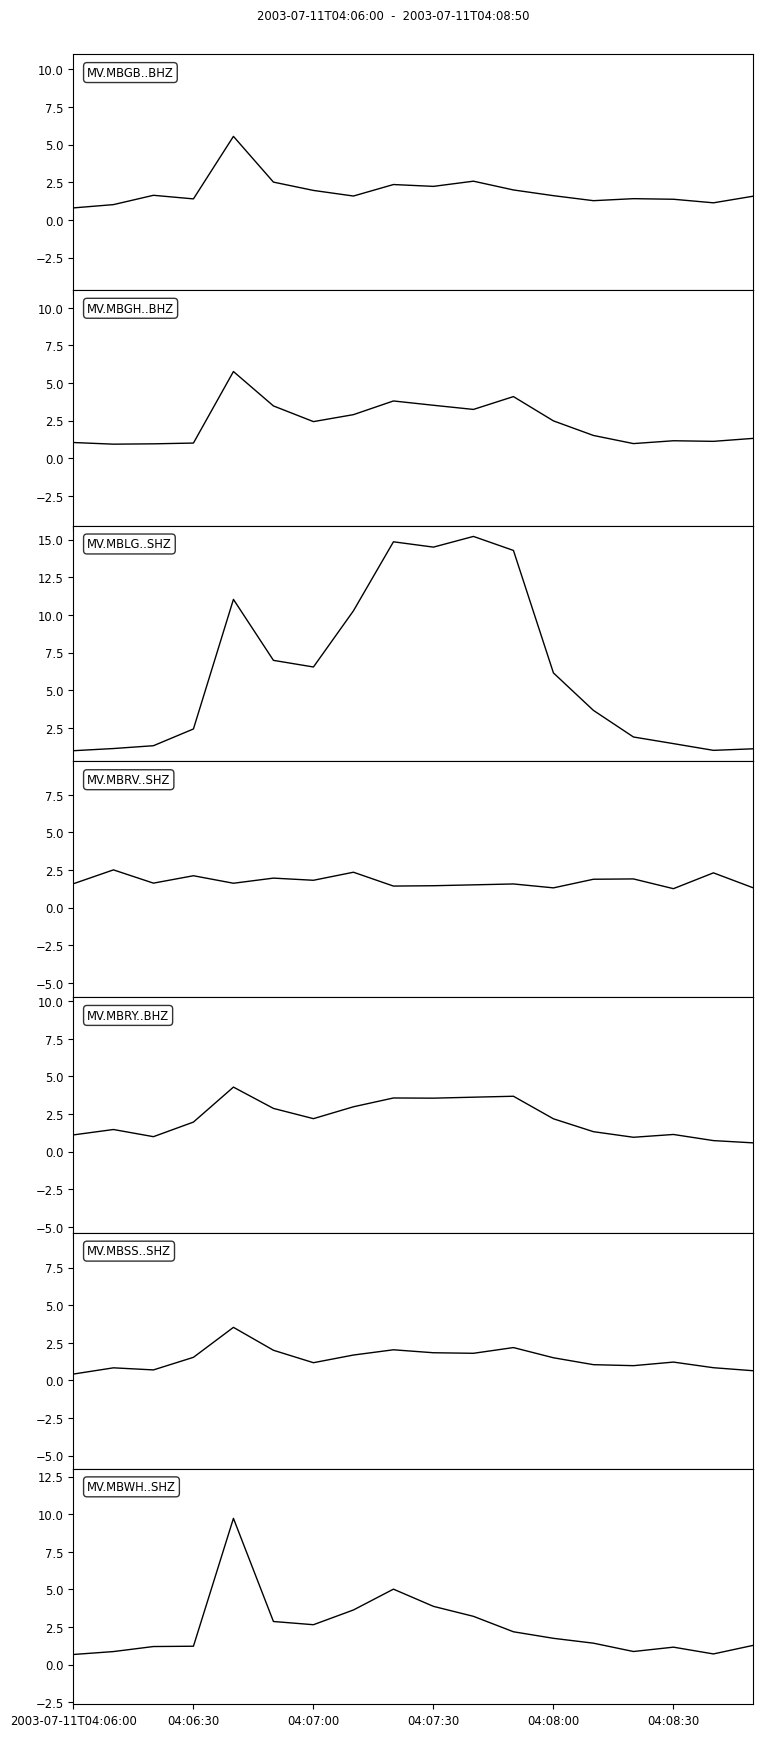

In [14]:
source1 = {'lat':16.71111, 'lon':-62.17722}
DRSobj = dsamObj.compute_reduced_displacement(invMVO, source1, surfaceWaves=True, Q=None, wavespeed_kms=1.5)

DRSmaxrms = DRSobj.max(metric='VT')
print(f'Maximum DRS assuming fixed source is: {DRSmaxrms}')
DRSobj.plot(equal_scale=True)

-62.21188369724058 -62.12834738850151 16.690895075330122 16.77089507533012
Loading EarthReliefData-62.170115542871045.16.73089507533012.1.03s.pkl


/home/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)
/superfast2TB/home2/thompsong/Developer/skience2024heiner/VolcanoSeismicMonitoring/src/lib/ASL.py:486: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x=x, y=y, size=symsize, style="cc", pen='1p,black', color=timecolor, cmap=True)


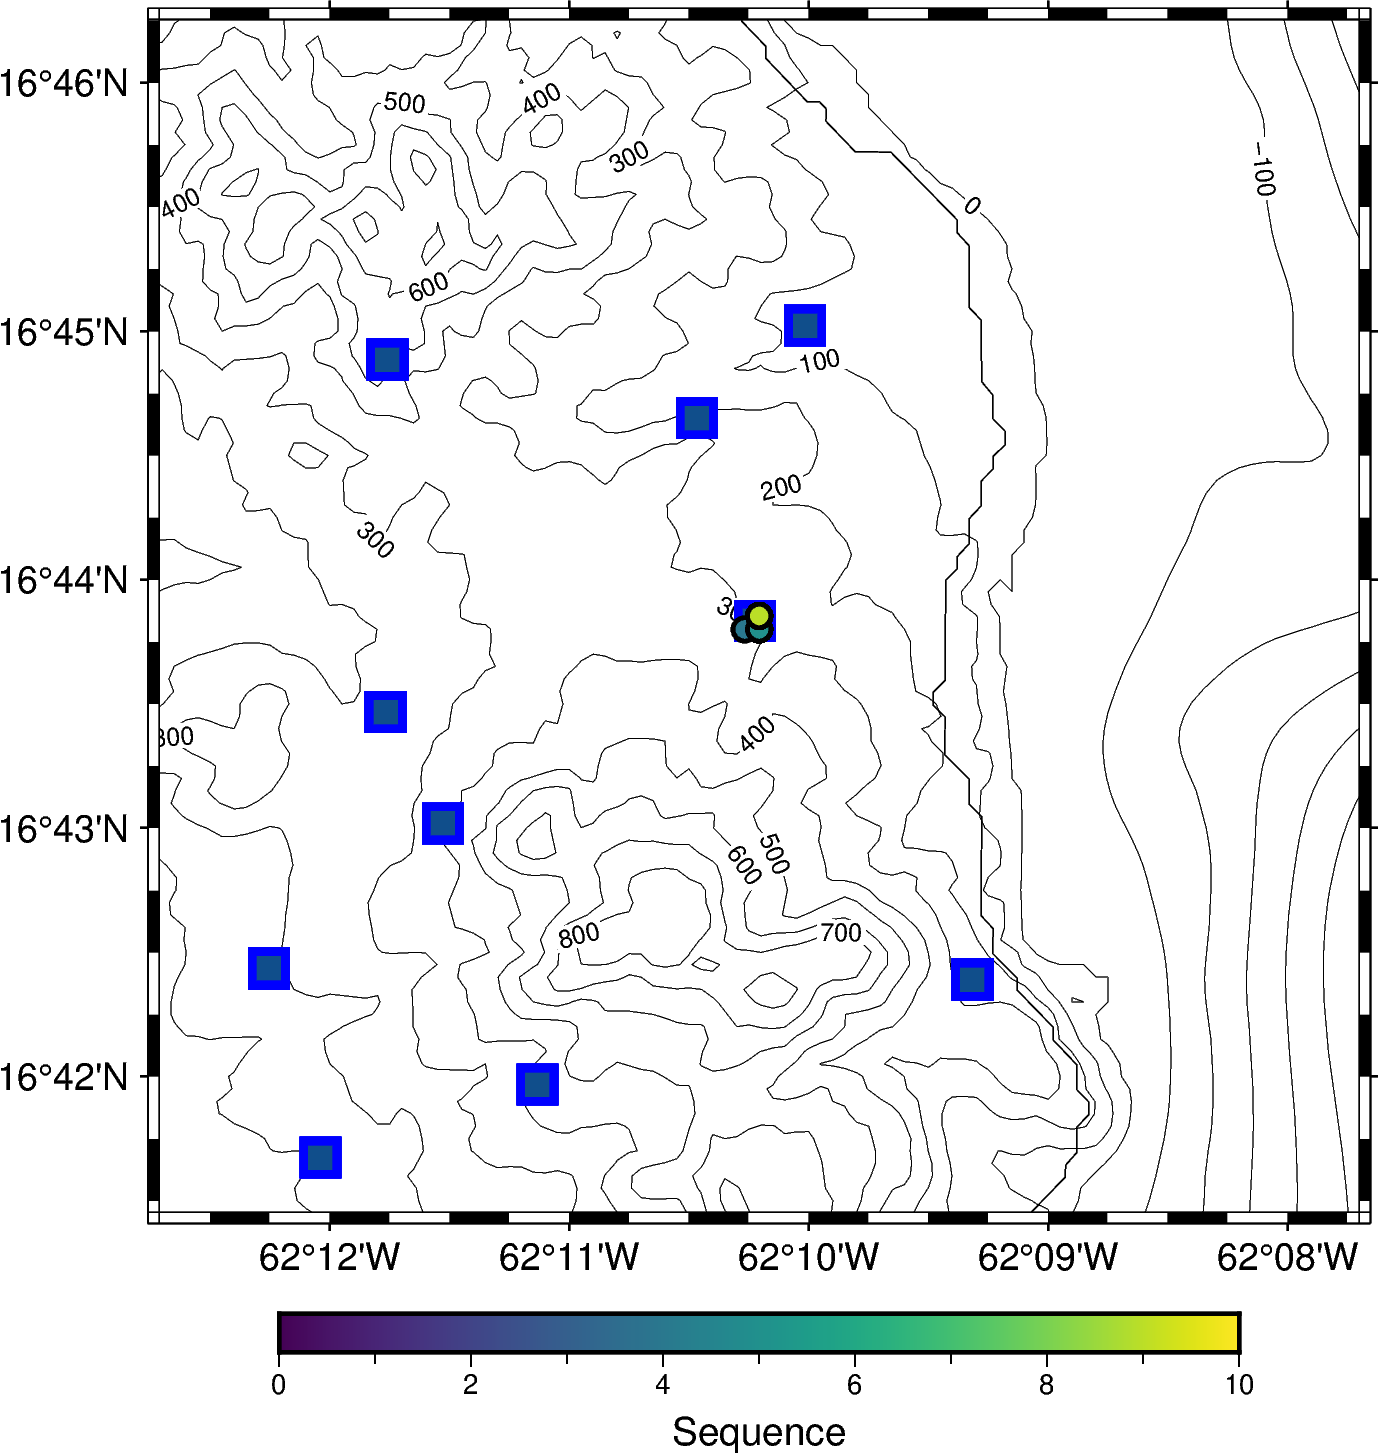

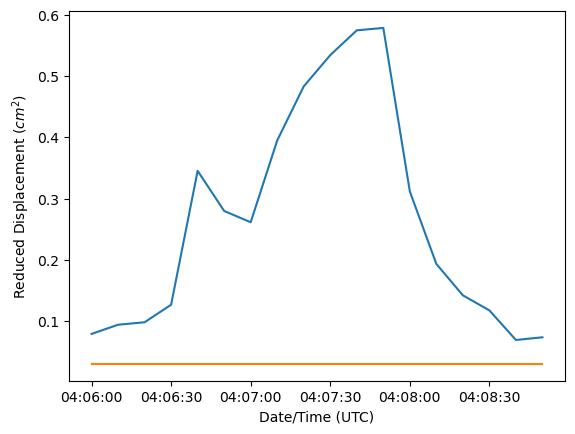

In [15]:
aslobj = ASL(dsamObj, 'VT', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=None, fix_peakf = peakf)

source_pf = aslobj.fast_locate()

aslobj.plot(source_pf, zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, equal_size=True, add_labels=False)

-62.180557581463425 -62.159673504278665 16.72089507533012 16.740895075330123
Loading EarthReliefData-62.170115542871045.16.73089507533012.3.03s.pkl


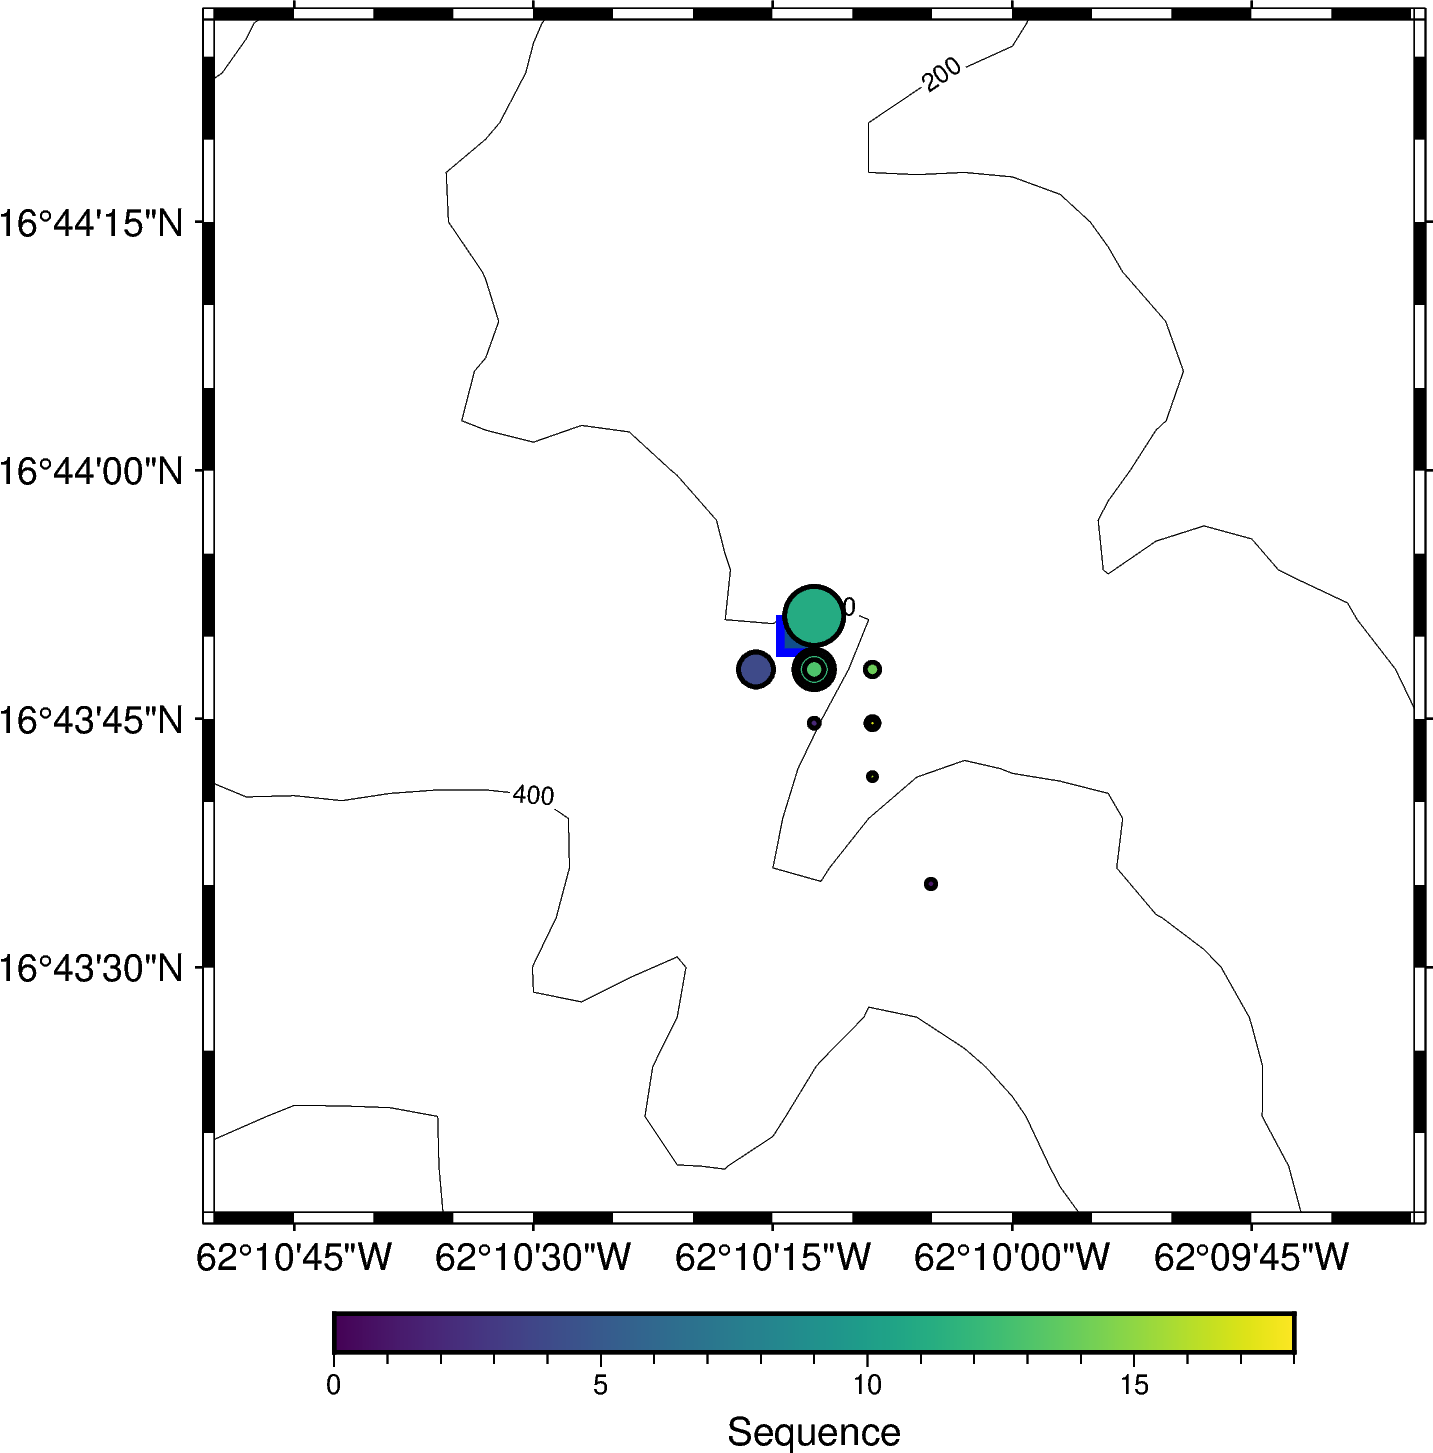

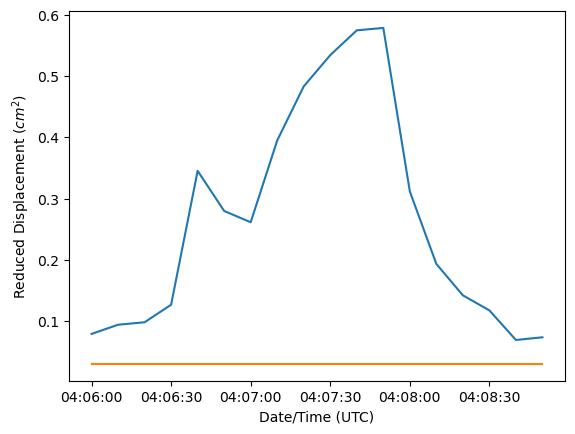

In [16]:
aslobj.plot(source_pf, zoom_level=3, threshold_DR=0.03, scale=0.5, join=True, number=30, add_labels=False)

## 5. Summary

I call the approach above "naive" ASL, because for simplicity (and speed, for real-time application) it ignores the vertical dimension, and assumes a homogeneous, isotropic half space (1-layer). It also considers the seismic source to be a point source, and assumes only one event is occurring at a time. In reality, pyroclastic flows cause multiple seismic sources per unit time, over an extended area, and this evolves with time as the flow moves downhill. Moreover, there can be numerous pyroclastic flows travelling down different flanks of the volcano at the same time, such as in a major dome collapse which may be comprised of dozens of pyroclastic flows that reach the coast. The average location determined by ASL is likely the top of the dome. 